# Finding interrelations of the UN SDG Targets and impute missing observations

### This project is divided into two major phases: 
1. It is intended to find cliques within the [UN SDG](https://sustainabledevelopment.un.org/?menu=1300) Targets.
2. Within one of the found cliques, missing observations of the time-series are inferred

Each Target has at least one quantitatively measurable Indicator associated whose measurements from 1984 to 2017 serve as our data points. The data set we are working with is for the entire world, i.e. the values presented are means over all countries. Regarding the first phase, for a more sophisticated analysis, but out of scope of this course, correlations in each country should be analysed separately.

<img src="Screenshot from 2018-04-19 10-08-40.png">

## 1. Find cliques

Import necessary packages and load our preprocessed data set

*if you want to see what happened in the preprocessing, see **prepare_df_for_analysis.ipynb** *

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pystan
import math
import os
import sklearn

In [2]:
# load csv
df = pd.read_csv("TargetsForAnalysis.csv")
df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.7,NaN,NaN,NaN,NaN
1,107,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
2,108,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
3,109,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
4,110,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN


See how many data points we have for each Indicator

In [3]:
intyears = list(range(1984, 2018))
#print(intyears)

years = []
for year in intyears:
    years.append(str(year))
    
#print(years)

In [4]:
def getnumberofyearswithdata(r):
    n = 0
    for year in years:
        if ~np.isnan(r[year]):
            n+=1
    return n

In [5]:
# new column with number of data points per Indicator
df['Years with values'] = df.apply(getnumberofyearswithdata, axis=1)

In [6]:
df.head()
df.shape

(197, 43)

We need at least two data points to conclude any kind of correlation

In [7]:
df_new = df.loc[df['Years with values'] > 1]

# see how many rows we deleted
print(df_new.shape)
df_new.head()

(120, 43)


,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN,2
8,115,Population,Proportion of births attended by skilled healt...,3,3.1,3.1.2,Percent,Units,NaN,NaN,...,NaN,69.88,NaN,NaN,NaN,NaN,NaN,78.49,NaN,3
9,129,Population,Participation rate in organized learning (one ...,4,4.2,4.2.2,Percent,Units,NaN,NaN,...,59.41,60.44,62.64,64.64,65.20,66.59,NaN,NaN,NaN,12
10,130,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,54.02,55.55,55.91,55.77,55.22,55.03,54.81,NaN,NaN,16
11,131,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,69.90,70.82,71.14,71.22,71.09,71.14,71.16,NaN,NaN,16


See how many Targets are associated with the Indicators we found

In [8]:
# create a list of Targets
e = list(df_new['Target'])
type(e[2])

str

In [9]:
df_new['Target'] = df_new.apply(lambda x: str(x['Target']), axis=1)

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
df_new.shape

(120, 43)

See which Targets are in our data frame

In [11]:
targets = list(set(df_new['Target']))

We know that one Target can have potentially more than one Indicator, and that Indicators can be separetely measured for, e.g., genders, age groups, etc.
But since we want to find interrelations between the Targets, only the row per Target with maximum amount of data is considered.

In [12]:
# create empty dictionary
target_dfs = {}

In [13]:
for t in targets:
    target_dfs[t] = df_new[df_new['Target']==t]

In [14]:
# show an example of Target with more than on Indicator
target_dfs['12.2']

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.690000e+00,1.010000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
178,78,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
179,79,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,6.573055e+16,6.932903e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
183,83,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,9.750000e+00,1.006000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
184,84,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
185,85,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,6.807354e+16,7.099971e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [15]:
# find row with maximum amount of data points for each target
max_dfrows = {}

for target in targets:
    if target_dfs[target].shape[0] > 1:
        max_dfrows[target] = target_dfs[target].loc[target_dfs[target]['Years with values'].idxmax()].to_frame().T
    else:
        max_dfrows[target]=target_dfs[target]

In [16]:
frames = list(max_dfrows[target] for target in targets)

In [17]:
merged_df = pd.concat(frames, axis=0)

In [18]:
units = list(set(merged_df['Unit']))

In [19]:
units.remove('Percent')
units

['USD', 'Metric Tons', 'Constant USD']

In [20]:
not_percent = merged_df[merged_df['Unit'].isin(units)]
not_percent

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
191,95,Environment (Tonnes),CO2 emission per unit of value added,9,9.4,9.4.1,Metric Tons,Units,NaN,NaN,...,2.87486e+10,3.04504e+10,3.13544e+10,3.15929e+10,3.21294e+10,3.2381e+10,NaN,NaN,NaN,15
140,20,E&P (Percent),"Net official development assistance, total and...",17,17.2,17.2.1,Constant USD,Billions,NaN,NaN,...,0.000114281,0.00012063,0.000119673,0.000115308,0.000121838,0.000123946,0.000131555,0.000143329,NaN,17
141,36,E&P (USD),Dollar value of all resources made available t...,17,17.19,17.19.1,USD,Units,NaN,NaN,...,1.40685e+08,3.51996e+08,4.83067e+08,2.08601e+08,4.43106e+08,3.49844e+08,NaN,NaN,NaN,9
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
174,74,Environment (Tonnes),"Material footprint, material footprint per cap...",8,8.4,8.4.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [21]:
merged_df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
103,167,Population,Researchers (in full-time equivalent) per mill...,9,9.5,9.5.2,Percent,Millions,NaN,NaN,...,100.752,101.895,104.668,106.636,108.754,109.838,NaN,NaN,NaN,15
191,95,Environment (Tonnes),CO2 emission per unit of value added,9,9.4,9.4.1,Metric Tons,Units,NaN,NaN,...,2.87486e+10,3.04504e+10,3.13544e+10,3.15929e+10,3.21294e+10,3.2381e+10,NaN,NaN,NaN,15
65,123,Population,Death rate due to road traffic injuries,3,3.6,3.6.1,Percent,Units,NaN,NaN,...,NaN,1.8,NaN,NaN,1.74,NaN,NaN,NaN,NaN,4
57,114,Population,Maternal mortality ratio,3,3.1,3.1.1,Percent,Units,NaN,NaN,...,NaN,24.6,NaN,NaN,NaN,NaN,21.6,NaN,NaN,4
64,121,Population,Suicide mortality rate,3,3.4,3.4.2,Percent,Units,NaN,NaN,...,NaN,1.123,NaN,NaN,NaN,NaN,1.073,NaN,NaN,4


### clean-up data frames

In [22]:
# Drop unused columns, transpose
final_df = merged_df.copy()

final_df.drop(['Unnamed: 0', 'Category', 'Indicator Description', 'Goal', 'Indicator Ref', 'Unit',
              'Unit multiplier', 'Years with values'], inplace=True, axis=1)

final_df = final_df.set_index('Target')

final_t = final_df.T

targets = list(final_t.columns)

In [23]:
final_t

Target,9.5,9.4,3.6,3.1,3.4,15.1,1.1,4.2,16.a,8.1,...,12.2,2.1,7.2,16.3,6.2,6.1,14.4,9.2,8.4,10.c
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,50.27,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,43.98,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,42.63,NaN,NaN,NaN
1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,50,NaN,NaN,NaN
1991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.5,NaN,NaN,NaN,NaN,45.95,NaN,NaN,NaN
1993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# shuffle data
final_t_shuffled = sklearn.utils.shuffle(final_t, random_state=200)#final_t.sample(frac=1, random_state=200).reset_index(drop=True)
final_t_shuffled

Target,9.5,9.4,3.6,3.1,3.4,15.1,1.1,4.2,16.a,8.1,...,12.2,2.1,7.2,16.3,6.2,6.1,14.4,9.2,8.4,10.c
2002,83.458,2.38841e+10,NaN,NaN,NaN,34.16,NaN,NaN,NaN,0.86,...,8.1,15,17.29,NaN,32.72,42.84,NaN,14.81,8.1,NaN
2016,NaN,NaN,NaN,NaN,NaN,43.23,NaN,NaN,36.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.16,NaN,NaN
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,16.1,NaN,NaN,NaN,NaN,49.73,NaN,NaN,NaN
2015,NaN,NaN,NaN,21.6,1.073,43.23,NaN,NaN,35.5,1.45,...,NaN,10.8,NaN,31,23.97,54.81,NaN,16.11,NaN,7.5
2012,106.636,3.15929e+10,NaN,NaN,NaN,42.7,NaN,64.64,NaN,1.01,...,NaN,11.4,17.91,NaN,26.23,55.77,NaN,15.94,NaN,9
2008,98.358,2.91648e+10,NaN,NaN,NaN,41.28,NaN,58.89,NaN,0.2,...,9.78,13,17.14,NaN,28.98,52.49,52.83,15.74,9.78,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,43.98,NaN,NaN,NaN
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006,92.935,2.78903e+10,NaN,NaN,NaN,39.42,NaN,58.66,NaN,2.77,...,9.42,14.3,16.97,NaN,30.32,49.46,51.51,15.61,9.42,NaN


### Structure Learning

We learn the structure of the network by deploying linear regression and calculate error measurements. In detail, we say that a correlation between two Targets exists, if the mean average error (MAE) is lower than 1%.

In [25]:
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import Imputer

In [26]:
def compute_error(trues, predicted):
    mae = np.mean(np.abs(predicted - trues))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    
    if len(trues)>2:
        rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
        r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    else:
        rae = np.nan
        r2 = np.nan
    return mae, rae, rmse, r2

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


9.4 9.5
MAE: 1.44397
RMSE: 1.65939
R2: 0.969
Coefficient 3.099200441428007e-09
--------------------------


9.4 3.6
MAE: 0.10044
RMSE: 0.13263
R2: nan
Coefficient -2.7496106354939404e-11
--------------------------


9.4 15.1
MAE: 0.85686
RMSE: 1.03339
R2: 0.928
Coefficient 1.0743549115940195e-09
--------------------------


9.4 4.2
MAE: 1.42393
RMSE: 1.78328
R2: 0.687
Coefficient 1.7219216738487998e-09
--------------------------


9.4 8.1
MAE: 1.36123
RMSE: 1.78482
R2: 0.000
Coefficient -2.3704698198997093e-11
--------------------------


9.4 8.2
MAE: 1.12383
RMSE: 1.37377
R2: 0.000
Coefficient 7.272512504957432e-12
--------------------------


9.4 17.2
MAE: 0.00001
RMSE: 0.00001
R2: 0.833
Coefficient 4.84725936945202e-15
--------------------------


9.4 3.3
MAE: 0.27585
RMSE: 0.33035
R2: 0.875
Coefficient -3.068140209204522e-10
--------------------------


9.4 17.3
MAE: 0.02557
RMSE: 0.03447
R2: 0.901
Coefficient 2.87693690971339e-11
--------------------------


9.4 9.c
MAE: 5.68008
R

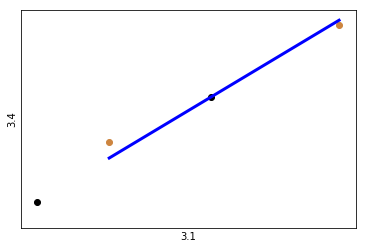

3.1 3.4
MAE: 0.00856
RMSE: 0.00980
R2: nan
Coefficient 0.012222222222222235
--------------------------


3.1 15.1
MAE: 1.94729
RMSE: 2.34681
R2: nan
Coefficient -0.6458333333333333
--------------------------


3.1 16.a
MAE: 3.33611
RMSE: 4.33583
R2: nan
Coefficient -1.055555555555556
--------------------------




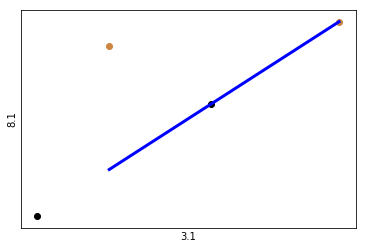

3.1 8.1
MAE: 0.49875
RMSE: 0.70357
R2: nan
Coefficient 0.12500000000000003
--------------------------




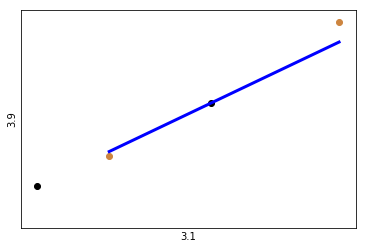

3.1 3.9
MAE: 0.00525
RMSE: 0.00617
R2: nan
Coefficient 0.005000000000000002
--------------------------


3.1 8.2
MAE: 1.33069
RMSE: 1.46425
R2: nan
Coefficient 0.15277777777777782
--------------------------


17.2 3.1
MAE: 8.11197
RMSE: 10.25469
R2: nan
Coefficient -442895.6765385244
--------------------------


17.2 17.8
MAE: 4.30063
RMSE: 5.69807
R2: 0.705
Coefficient 634202.0360383239
--------------------------


17.2 15.4
MAE: 1.00345
RMSE: 1.35397
R2: 0.846
Coefficient 139103.46637851716
--------------------------


17.2 7.1
MAE: 16.47934
RMSE: 23.18175
R2: nan
Coefficient 803735.8103044721
--------------------------


17.2 12.2
MAE: 0.26627
RMSE: 0.37448
R2: 0.728
Coefficient 43672.0940193962
--------------------------


17.2 2.1
MAE: 0.60352
RMSE: 0.92158
R2: 0.623
Coefficient -85140.94990713692
--------------------------


17.2 7.2
MAE: 0.33265
RMSE: 0.39545
R2: 0.130
Coefficient 14635.427761271036
--------------------------


17.2 6.2
MAE: 1.06924
RMSE: 1.41955
R2: 0.744
Coeff

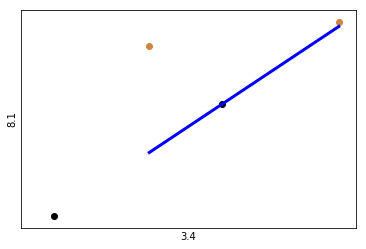

3.4 8.1
MAE: 0.44739
RMSE: 0.60769
R2: nan
Coefficient 10.22727272727272
--------------------------




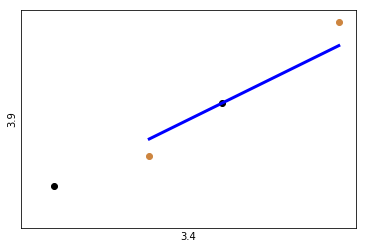

3.4 3.9
MAE: 0.00875
RMSE: 0.00885
R2: nan
Coefficient 0.40909090909090867
--------------------------


3.4 8.2
MAE: 1.22375
RMSE: 1.34218
R2: nan
Coefficient 12.499999999999988
--------------------------


17.2 3.4
MAE: 0.09437
RMSE: 0.12716
R2: nan
Coefficient -5413.1693799153045
--------------------------


15.1 9.5
MAE: 2.88052
RMSE: 3.15025
R2: 0.890
Coefficient 2.749746130660022
--------------------------


15.1 4.2
MAE: 2.45749
RMSE: 3.24521
R2: 0.000
Coefficient 1.9488598792356795
--------------------------


15.1 16.a
MAE: 10.33333
RMSE: 12.48012
R2: 0.000
Coefficient 0.0
--------------------------


15.1 8.1
MAE: 1.33323
RMSE: 1.78135
R2: 0.000
Coefficient -0.006275010999601889
--------------------------




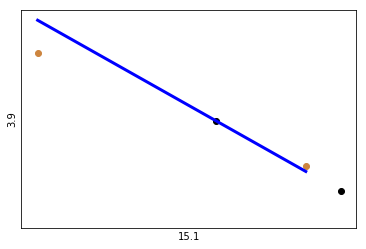

15.1 3.9
MAE: 0.00983
RMSE: 0.01200
R2: nan
Coefficient -0.00774193548387097
--------------------------


15.1 8.2
MAE: 1.05290
RMSE: 1.32674
R2: 0.000
Coefficient -0.006426421937253317
--------------------------


17.2 15.1
MAE: 1.34203
RMSE: 1.47086
R2: 0.857
Coefficient 146225.8859456459
--------------------------


4.2 9.5
MAE: 2.61512
RMSE: 3.01652
R2: 0.857
Coefficient 1.9832957013936892
--------------------------


4.2 8.1
MAE: 1.26570
RMSE: 1.85814
R2: 0.011
Coefficient -0.07852963325824519
--------------------------


4.2 8.2
MAE: 1.02576
RMSE: 1.45518
R2: 0.000
Coefficient -0.15570267187869577
--------------------------


17.2 4.2
MAE: 5.42372
RMSE: 6.74858
R2: 0.000
Coefficient 571895.9895128921
--------------------------




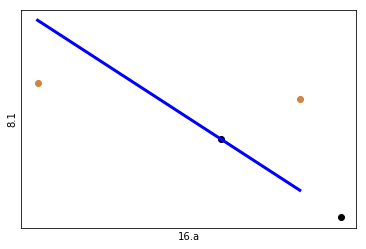

16.a 8.1
MAE: 0.89382
RMSE: 0.90952
R2: nan
Coefficient -0.11842105263157895
--------------------------




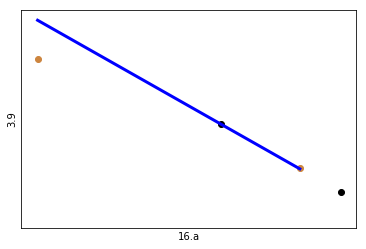

16.a 3.9
MAE: 0.01055
RMSE: 0.01445
R2: nan
Coefficient -0.004736842105263157
--------------------------


16.a 8.2
MAE: 2.84167
RMSE: 2.91770
R2: 0.000
Coefficient 0.13000000000000006
--------------------------


17.2 16.a
MAE: 7.34509
RMSE: 8.97269
R2: 0.000
Coefficient 84937.30352939968
--------------------------


8.1 9.5
MAE: 8.64530
RMSE: 9.79841
R2: 0.000
Coefficient -1.7342478207685397
--------------------------




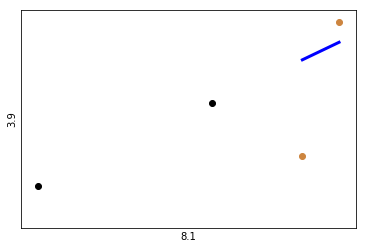

8.1 3.9
MAE: 0.02520
RMSE: 0.03018
R2: nan
Coefficient 0.04
--------------------------




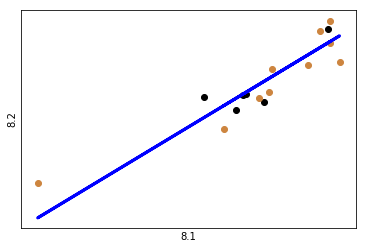

8.1 8.2
MAE: 0.49894
RMSE: 0.56971
R2: 0.826
Coefficient 0.8644141315103401
--------------------------


17.2 8.1
MAE: 1.35913
RMSE: 1.82708
R2: 0.000
Coefficient 6029.369241949056
--------------------------


3.9 8.2
MAE: 1.49111
RMSE: 1.57646
R2: nan
Coefficient 30.555555555555554
--------------------------


17.2 3.9
MAE: 0.03731
RMSE: 0.04554
R2: nan
Coefficient -2214.4783826926223
--------------------------


8.2 9.5
MAE: 8.68879
RMSE: 10.26816
R2: 0.000
Coefficient -0.8582728875597008
--------------------------


17.2 8.2
MAE: 1.05427
RMSE: 1.32676
R2: 0.000
Coefficient -604.8858705454962
--------------------------


17.2 9.5
MAE: 3.05154
RMSE: 4.36001
R2: 0.789
Coefficient 561007.4014136026
--------------------------


3.3 9.5
MAE: 2.01048
RMSE: 2.49561
R2: 0.931
Coefficient -9.637090420769916
--------------------------




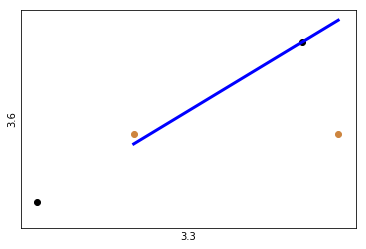

3.3 3.6
MAE: 0.05409
RMSE: 0.07036
R2: nan
Coefficient 0.06363636363636371
--------------------------


3.3 3.1
MAE: 2.48333
RMSE: 3.19904
R2: nan
Coefficient 2.666666666666668
--------------------------




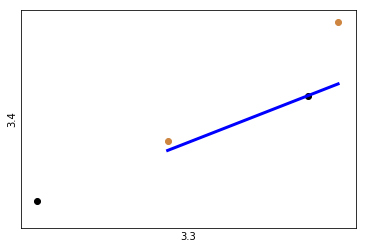

3.3 3.4
MAE: 0.02943
RMSE: 0.03662
R2: nan
Coefficient 0.03259259259259264
--------------------------


3.3 15.1
MAE: 1.74510
RMSE: 2.15919
R2: 0.687
Coefficient -2.6338942307692297
--------------------------




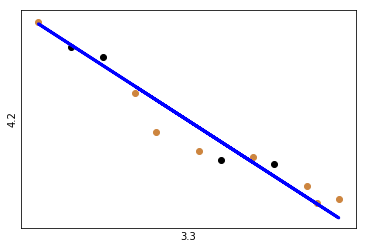

3.3 4.2
MAE: 0.69555
RMSE: 0.90304
R2: 0.920
Coefficient -3.8673553719008233
--------------------------


3.3 16.a
MAE: 5.95741
RMSE: 7.71249
R2: nan
Coefficient -2.8148148148148167
--------------------------


3.3 8.1
MAE: 1.32102
RMSE: 1.77315
R2: 0.000
Coefficient 0.05658653846153856
--------------------------




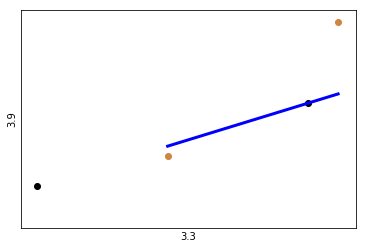

3.3 3.9
MAE: 0.01767
RMSE: 0.02213
R2: nan
Coefficient 0.01333333333333334
--------------------------


3.3 8.2
MAE: 1.09224
RMSE: 1.37570
R2: 0.000
Coefficient 0.208990384615385
--------------------------




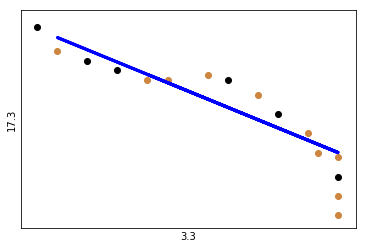

3.3 17.3
MAE: 0.04086
RMSE: 0.05640
R2: 0.734
Coefficient -0.08490384615384611
--------------------------




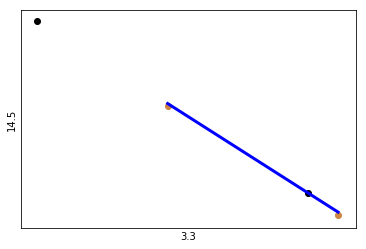

3.3 14.5
MAE: 0.14944
RMSE: 0.15043
R2: nan
Coefficient -3.3444444444444463
--------------------------


3.3 9.c
MAE: 6.65545
RMSE: 7.29977
R2: 0.743
Coefficient -11.523124999999995
--------------------------


17.19 3.3
MAE: 0.69219
RMSE: 0.75960
R2: 0.000
Coefficient -6.6652020540680895e-09
--------------------------


17.3 9.5
MAE: 2.24904
RMSE: 3.05319
R2: 0.897
Coefficient 101.67415966386557
--------------------------




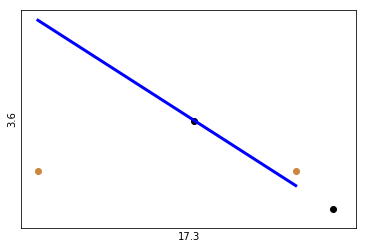

17.3 3.6
MAE: 0.13067
RMSE: 0.16952
R2: nan
Coefficient -0.9333333333333348
--------------------------




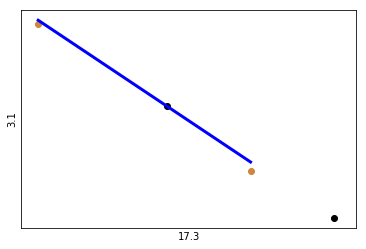

17.3 3.1
MAE: 0.43182
RMSE: 0.46341
R2: nan
Coefficient -32.72727272727273
--------------------------




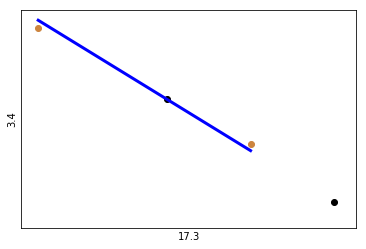

17.3 3.4
MAE: 0.00650
RMSE: 0.00652
R2: nan
Coefficient -0.40000000000000036
--------------------------




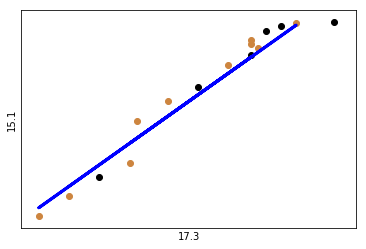

17.3 15.1
MAE: 0.67168
RMSE: 0.74594
R2: 0.963
Coefficient 31.423837209302327
--------------------------


17.3 4.2
MAE: 2.17038
RMSE: 2.50841
R2: 0.382
Coefficient 60.0836363636364
--------------------------


17.3 16.a
MAE: 3.51364
RMSE: 4.20696
R2: nan
Coefficient 34.545454545454554
--------------------------


17.3 8.1
MAE: 1.32604
RMSE: 1.77380
R2: 0.000
Coefficient -0.3517441860465126
--------------------------




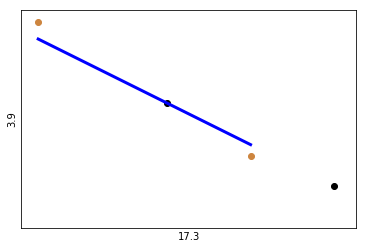

17.3 3.9
MAE: 0.00609
RMSE: 0.00619
R2: nan
Coefficient -0.16363636363636364
--------------------------


17.3 8.2
MAE: 1.12294
RMSE: 1.37848
R2: 0.000
Coefficient -0.8738372093023267
--------------------------


17.3 14.5
MAE: 2.92136
RMSE: 4.10676
R2: nan
Coefficient 41.04545454545455
--------------------------


17.3 9.c
MAE: 6.15383
RMSE: 10.33114
R2: 0.485
Coefficient 133.81976744186048
--------------------------


17.19 17.3
MAE: 0.11237
RMSE: 0.12583
R2: 0.000
Coefficient 8.519625592484218e-10
--------------------------


14.5 3.1
MAE: 2.46960
RMSE: 3.11440
R2: nan
Coefficient -0.7973421926910296
--------------------------




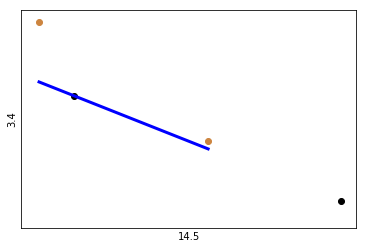

14.5 3.4
MAE: 0.02797
RMSE: 0.03536
R2: nan
Coefficient -0.009745293466223706
--------------------------


14.5 15.1
MAE: 5.76000
RMSE: 7.11059
R2: 0.000
Coefficient -0.0
--------------------------


14.5 16.a
MAE: 4.37886
RMSE: 4.72282
R2: 0.545
Coefficient 1.2195121951219503
--------------------------




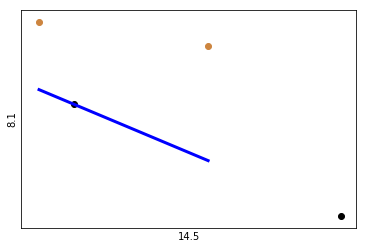

14.5 8.1
MAE: 0.73344
RMSE: 0.75766
R2: nan
Coefficient -0.09966777408637874
--------------------------




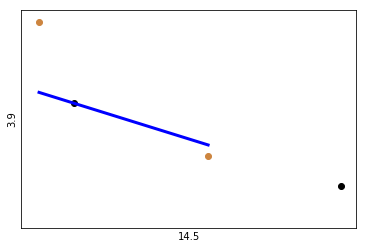

14.5 3.9
MAE: 0.01760
RMSE: 0.02172
R2: nan
Coefficient -0.003986710963455149
--------------------------


14.5 8.2
MAE: 2.81630
RMSE: 2.82620
R2: 0.000
Coefficient 0.15853658536585372
--------------------------


14.5 9.c
MAE: 13.54730
RMSE: 14.62161
R2: nan
Coefficient 3.537098560354374
--------------------------


9.c 9.5
MAE: 3.45523
RMSE: 5.42838
R2: 0.673
Coefficient 0.6546255365835474
--------------------------




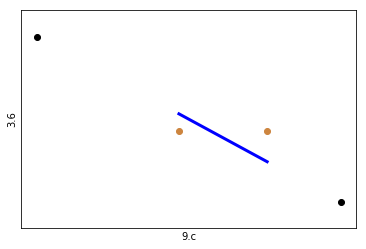

9.c 3.6
MAE: 0.02029
RMSE: 0.02112
R2: nan
Coefficient -0.004396984924623117
--------------------------


9.c 3.1
MAE: 4.95138
RMSE: 6.18691
R2: nan
Coefficient -0.22542266750156545
--------------------------




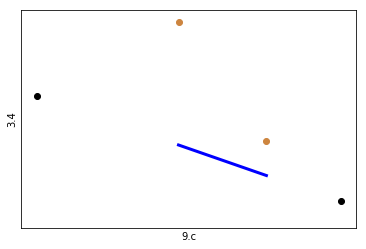

9.c 3.4
MAE: 0.06529
RMSE: 0.07494
R2: nan
Coefficient -0.002755165936130247
--------------------------


9.c 15.1
MAE: 1.56451
RMSE: 2.64330
R2: 0.531
Coefficient 0.23290574568597977
--------------------------


9.c 4.2
MAE: 3.58122
RMSE: 4.74256
R2: 0.000
Coefficient 0.45967038429318446
--------------------------


9.c 16.a
MAE: 7.99590
RMSE: 10.79463
R2: nan
Coefficient 0.23794614902943026
--------------------------


9.c 8.1
MAE: 1.34232
RMSE: 1.79463
R2: 0.000
Coefficient 0.0015360010994210254
--------------------------




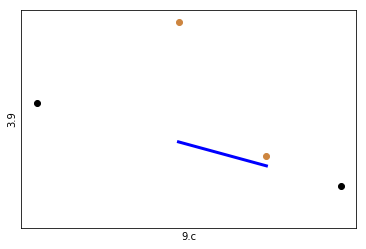

9.c 3.9
MAE: 0.02801
RMSE: 0.03675
R2: nan
Coefficient -0.0011271133375078274
--------------------------


9.c 8.2
MAE: 1.14099
RMSE: 1.38874
R2: 0.000
Coefficient 0.000799906624019251
--------------------------


17.19 9.c
MAE: 6.04664
RMSE: 6.62347
R2: 0.000
Coefficient 6.209214840822085e-08
--------------------------


17.19 9.5
MAE: 7.30274
RMSE: 8.31660
R2: 0.000
Coefficient 7.007834909584254e-08
--------------------------


17.19 15.1
MAE: 2.82989
RMSE: 3.12830
R2: 0.000
Coefficient 2.3176082789834703e-08
--------------------------


17.19 4.2
MAE: 2.05952
RMSE: 2.59311
R2: 0.179
Coefficient 6.242359208422907e-09
--------------------------


17.19 8.1
MAE: 5.98952
RMSE: 6.22818
R2: 0.000
Coefficient -3.034380073800204e-08
--------------------------


17.19 8.2
MAE: 4.59924
RMSE: 4.80323
R2: 0.000
Coefficient -2.419322153991645e-08
--------------------------


17.8 9.5
MAE: 1.04747
RMSE: 1.26896
R2: 0.982
Coefficient 0.9071327559994178
--------------------------




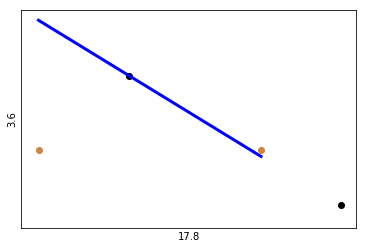

17.8 3.6
MAE: 0.07369
RMSE: 0.09922
R2: nan
Coefficient -0.006535947712418308
--------------------------


17.8 3.1
MAE: 1.84968
RMSE: 2.14379
R2: nan
Coefficient -0.2572347266881029
--------------------------




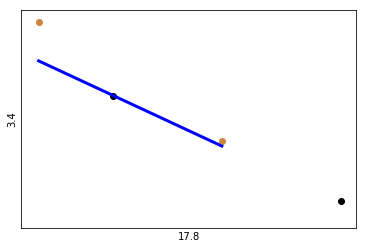

17.8 3.4
MAE: 0.01802
RMSE: 0.02285
R2: nan
Coefficient -0.0031439799928545935
--------------------------


17.8 15.1
MAE: 1.47793
RMSE: 1.78917
R2: 0.785
Coefficient 0.24438055217149088
--------------------------




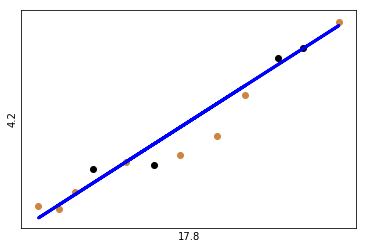

17.8 4.2
MAE: 0.62906
RMSE: 0.88066
R2: 0.924
Coefficient 0.3687249353422961
--------------------------


17.8 16.a
MAE: 5.28855
RMSE: 6.57903
R2: nan
Coefficient 0.27152554483744196
--------------------------


17.8 8.1
MAE: 1.32215
RMSE: 1.77198
R2: 0.000
Coefficient -0.005271926993890775
--------------------------




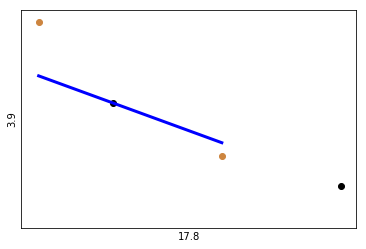

17.8 3.9
MAE: 0.01450
RMSE: 0.01689
R2: nan
Coefficient -0.0012861736334405145
--------------------------


17.8 8.2
MAE: 1.09414
RMSE: 1.38028
R2: 0.000
Coefficient -0.01921099280368023
--------------------------




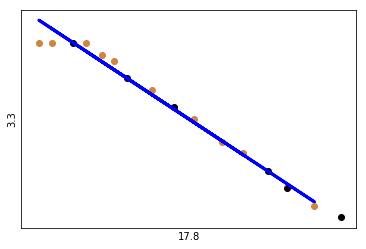

17.8 3.3
MAE: 0.13161
RMSE: 0.17243
R2: 0.966
Coefficient -0.09236806055819015
--------------------------




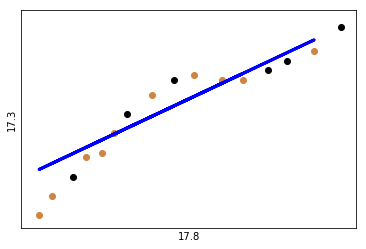

17.8 17.3
MAE: 0.03435
RMSE: 0.04400
R2: 0.838
Coefficient 0.007904584679647187
--------------------------


17.8 14.5
MAE: 1.02057
RMSE: 1.28299
R2: nan
Coefficient 0.32261521972132895
--------------------------


17.8 9.c
MAE: 7.01223
RMSE: 8.14272
R2: 0.680
Coefficient 1.066771472516718
--------------------------




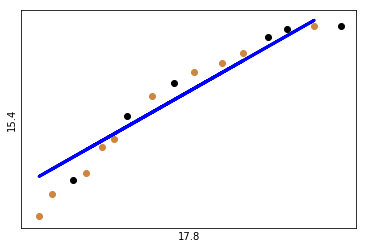

17.8 15.4
MAE: 0.82989
RMSE: 1.00274
R2: 0.908
Coefficient 0.24799591869889184
--------------------------




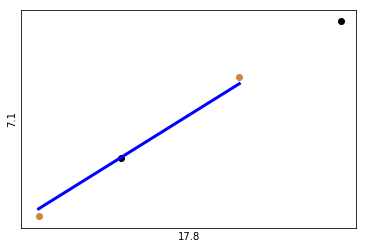

17.8 7.1
MAE: 0.35633
RMSE: 0.35633
R2: nan
Coefficient 0.2810351799433888
--------------------------


12.2 17.8
MAE: 2.10170
RMSE: 2.72705
R2: 0.859
Coefficient 7.3968224299065435
--------------------------




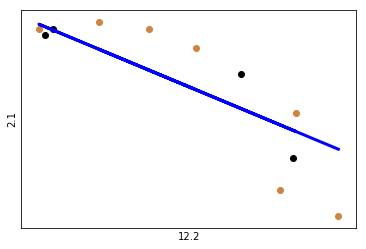

12.2 2.1
MAE: 0.58667
RMSE: 0.67395
R2: 0.670
Coefficient -0.9221183800623053
--------------------------




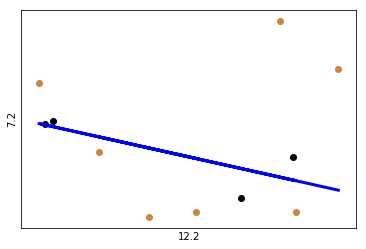

12.2 7.2
MAE: 0.29162
RMSE: 0.35259
R2: 0.000
Coefficient -0.13333333333333353
--------------------------




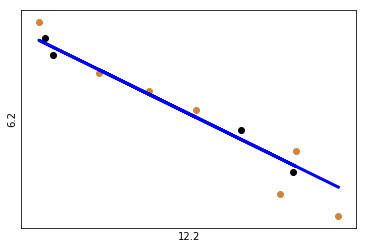

12.2 6.2
MAE: 0.50819
RMSE: 0.62736
R2: 0.904
Coefficient -2.232834890965733
--------------------------




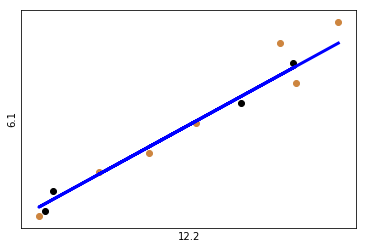

12.2 6.1
MAE: 0.94574
RMSE: 1.23218
R2: 0.937
Coefficient 5.901682242990654
--------------------------


12.2 14.4
MAE: 3.14000
RMSE: 3.57269
R2: 0.279
Coefficient 3.666666666666673
--------------------------




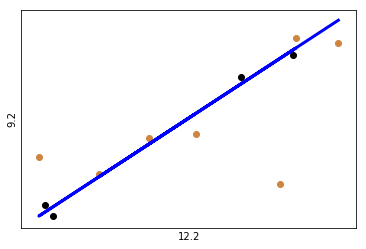

12.2 9.2
MAE: 0.20548
RMSE: 0.31303
R2: 0.052
Coefficient 0.5396261682242991
--------------------------




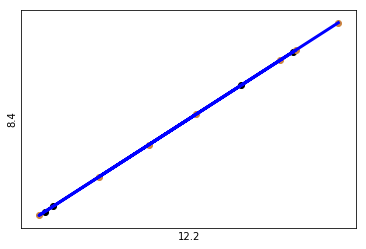

12.2 8.4
MAE: 0.00000
RMSE: 0.00000
R2: 1.000
Coefficient 1.0000000000000002
--------------------------


15.4 9.5
MAE: 1.35177
RMSE: 1.69466
R2: 0.968
Coefficient 3.0988217269968814
--------------------------




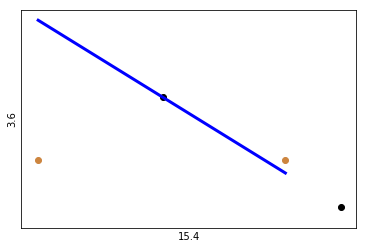

15.4 3.6
MAE: 0.09729
RMSE: 0.12641
R2: nan
Coefficient -0.023728813559322062
--------------------------




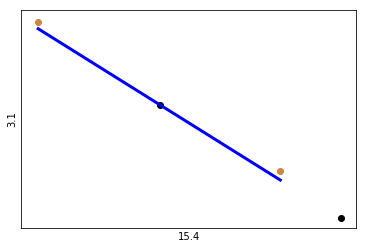

15.4 3.1
MAE: 0.51465
RMSE: 0.52105
R2: nan
Coefficient -1.178396072013093
--------------------------




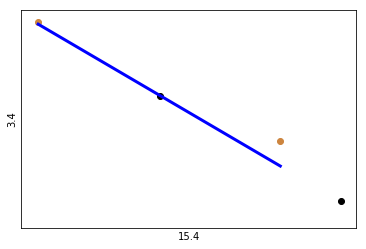

15.4 3.4
MAE: 0.01107
RMSE: 0.01462
R2: nan
Coefficient -0.01440261865793782
--------------------------




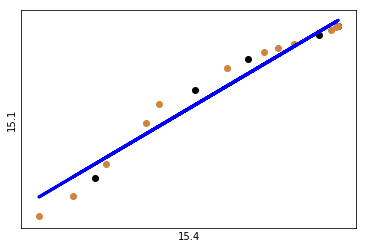

15.4 15.1
MAE: 0.67028
RMSE: 0.76953
R2: 0.961
Coefficient 1.0314565676771177
--------------------------


15.4 4.2
MAE: 1.54121
RMSE: 1.83046
R2: 0.671
Coefficient 1.538715697794983
--------------------------


15.4 16.a
MAE: 194.50000
RMSE: 220.92590
R2: 0.000
Coefficient 33.33333333333206
--------------------------


15.4 8.1
MAE: 1.31788
RMSE: 1.76560
R2: 0.000
Coefficient -0.021151668559050877
--------------------------




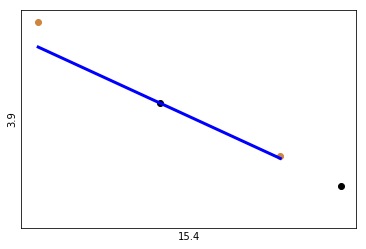

15.4 3.9
MAE: 0.00582
RMSE: 0.00757
R2: nan
Coefficient -0.005891980360065466
--------------------------


15.4 8.2
MAE: 1.02402
RMSE: 1.31963
R2: 0.000
Coefficient -0.04495032975627363
--------------------------




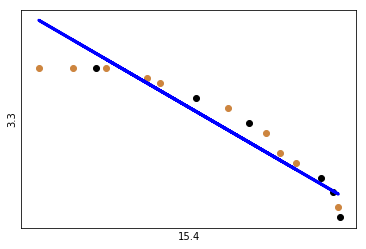

15.4 3.3
MAE: 0.33440
RMSE: 0.42363
R2: 0.794
Coefficient -0.3437658394097612
--------------------------




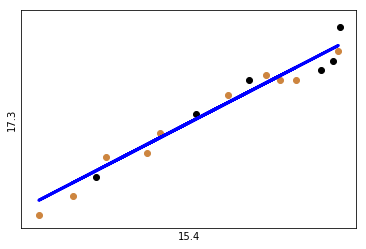

15.4 17.3
MAE: 0.01806
RMSE: 0.01956
R2: 0.968
Coefficient 0.031397657962726463
--------------------------


15.4 14.5
MAE: 159.65000
RMSE: 182.86676
R2: 0.000
Coefficient 27.3333333333323
--------------------------


15.4 9.c
MAE: 5.10963
RMSE: 9.25937
R2: 0.587
Coefficient 4.453894588294746
--------------------------


15.4 7.1
MAE: 1.16940
RMSE: 1.32329
R2: nan
Coefficient 1.1449752883031306
--------------------------




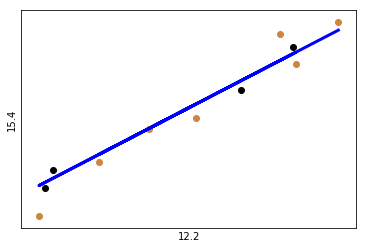

12.2 15.4
MAE: 0.59433
RMSE: 0.72947
R2: 0.931
Coefficient 3.138193146417447
--------------------------


7.1 9.5
MAE: 1.07878
RMSE: 1.43158
R2: nan
Coefficient 2.7483453237410047
--------------------------


7.1 15.1
MAE: 2.67683
RMSE: 3.37348
R2: nan
Coefficient 0.6633093525179855
--------------------------




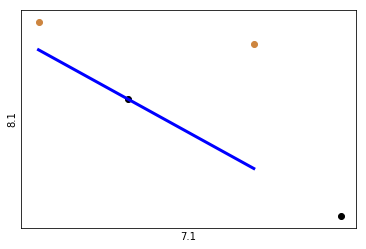

7.1 8.1
MAE: 0.64917
RMSE: 0.76898
R2: nan
Coefficient -0.1438848920863309
--------------------------


7.1 8.2
MAE: 1.09698
RMSE: 1.34408
R2: nan
Coefficient -0.139568345323741
--------------------------




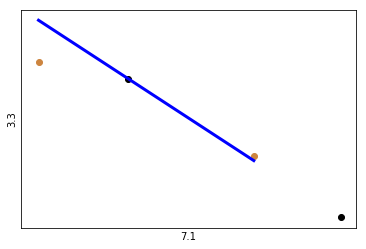

7.1 3.3
MAE: 0.41799
RMSE: 0.53853
R2: nan
Coefficient -0.35971223021582704
--------------------------




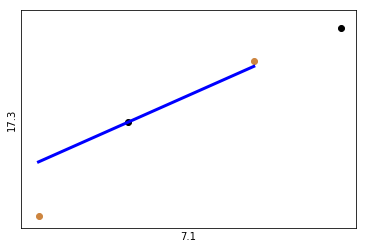

7.1 17.3
MAE: 0.05378
RMSE: 0.06968
R2: nan
Coefficient 0.024460431654676245
--------------------------


7.1 9.c
MAE: 16.82222
RMSE: 20.47436
R2: nan
Coefficient 4.6201438848920855
--------------------------


12.2 9.5
MAE: 1.72828
RMSE: 2.04544
R2: 0.922
Coefficient 8.490554517133955
--------------------------




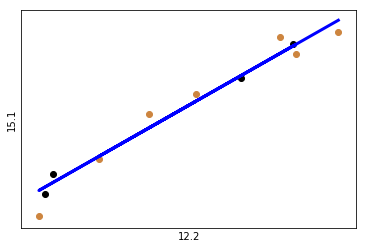

12.2 15.1
MAE: 0.68818
RMSE: 0.77889
R2: 0.949
Coefficient 4.436137071651092
--------------------------




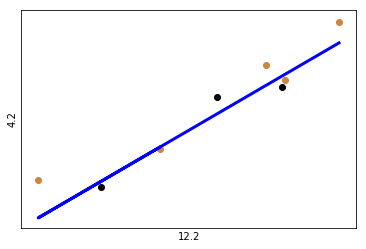

12.2 4.2
MAE: 0.41259
RMSE: 0.51328
R2: 0.858
Coefficient 2.470487215367005
--------------------------


12.2 8.1
MAE: 1.82093
RMSE: 2.19188
R2: 0.000
Coefficient 0.2876012461059194
--------------------------


12.2 8.2
MAE: 1.32384
RMSE: 1.65040
R2: 0.000
Coefficient 0.9172585669781937
--------------------------




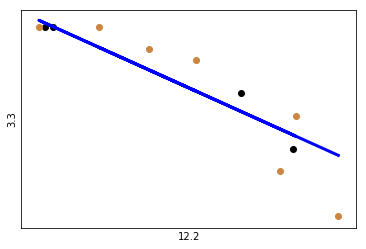

12.2 3.3
MAE: 0.25943
RMSE: 0.29880
R2: 0.769
Coefficient -0.5775700934579425
--------------------------




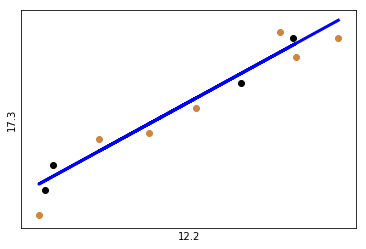

12.2 17.3
MAE: 0.02570
RMSE: 0.02814
R2: 0.915
Coefficient 0.1233021806853583
--------------------------


12.2 9.c
MAE: 7.58750
RMSE: 10.21922
R2: 0.264
Coefficient 16.44735202492212
--------------------------


2.1 9.5
MAE: 1.89939
RMSE: 2.52024
R2: 0.930
Coefficient -5.99238161559889
--------------------------




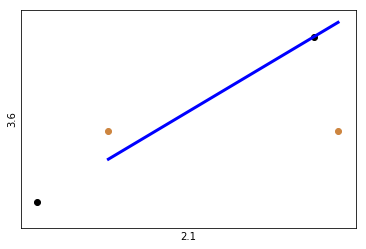

2.1 3.6
MAE: 0.05800
RMSE: 0.06723
R2: nan
Coefficient 0.040000000000000036
--------------------------


2.1 3.1
MAE: 2.67308
RMSE: 3.38275
R2: nan
Coefficient 1.846153846153847
--------------------------




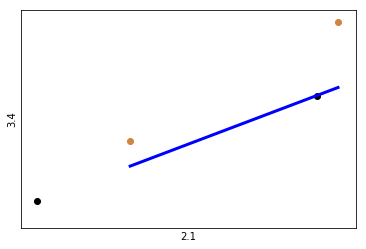

2.1 3.4
MAE: 0.03745
RMSE: 0.04104
R2: nan
Coefficient 0.022564102564102594
--------------------------


2.1 15.1
MAE: 1.55720
RMSE: 2.05813
R2: 0.716
Coefficient -1.8009278239292261
--------------------------


2.1 4.2
MAE: 1.09782
RMSE: 1.35229
R2: 0.820
Coefficient -2.292954990215265
--------------------------


2.1 16.a
MAE: 5.59103
RMSE: 7.85991
R2: nan
Coefficient -1.94871794871795
--------------------------


2.1 8.1
MAE: 1.29010
RMSE: 1.74279
R2: 0.019
Coefficient 0.09037652389686054
--------------------------




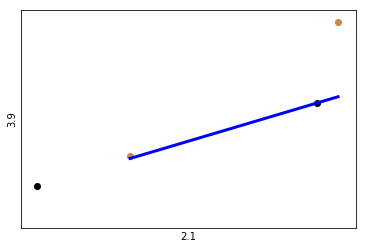

2.1 3.9
MAE: 0.01662
RMSE: 0.02280
R2: nan
Coefficient 0.009230769230769235
--------------------------


2.1 8.2
MAE: 1.08193
RMSE: 1.36678
R2: 0.000
Coefficient 0.16561657136692207
--------------------------




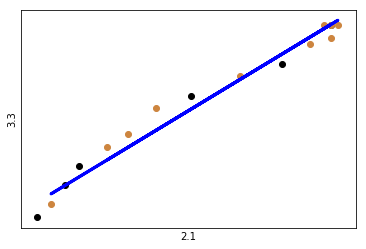

2.1 3.3
MAE: 0.14433
RMSE: 0.17357
R2: 0.965
Coefficient 0.6626389038731254
--------------------------




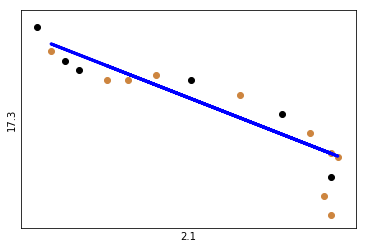

2.1 17.3
MAE: 0.03765
RMSE: 0.05466
R2: 0.751
Coefficient -0.0566619915848527
--------------------------




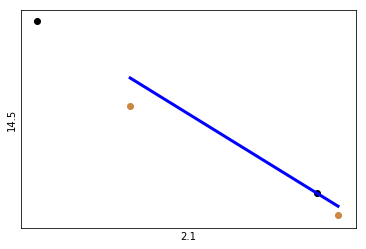

2.1 14.5
MAE: 0.97269
RMSE: 1.09245
R2: nan
Coefficient -2.3153846153846165
--------------------------


2.1 9.c
MAE: 5.11595
RMSE: 6.43553
R2: 0.800
Coefficient -7.805944546337253
--------------------------


2.1 17.8
MAE: 2.52283
RMSE: 2.74324
R2: 0.932
Coefficient -7.165087927500267
--------------------------




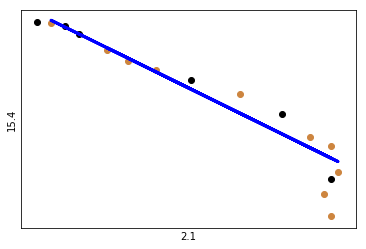

2.1 15.4
MAE: 0.83853
RMSE: 1.25196
R2: 0.857
Coefficient -1.82322796418168
--------------------------


2.1 7.1
MAE: 1.57514
RMSE: 1.76726
R2: nan
Coefficient -1.8783783783783794
--------------------------




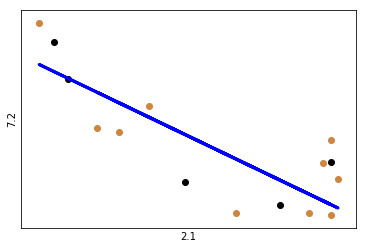

2.1 7.2
MAE: 0.24841
RMSE: 0.27708
R2: 0.573
Coefficient -0.26175139275766074
--------------------------




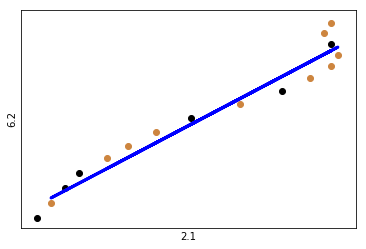

2.1 6.2
MAE: 0.66991
RMSE: 0.75464
R2: 0.928
Coefficient 1.8497141007659932
--------------------------


2.1 6.1
MAE: 2.13427
RMSE: 2.53772
R2: 0.795
Coefficient -2.600442334663932
--------------------------


2.1 14.4
MAE: 2.99505
RMSE: 3.29122
R2: 0.738
Coefficient -1.664513618677043
--------------------------




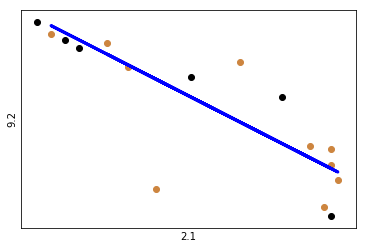

2.1 9.2
MAE: 0.18532
RMSE: 0.28641
R2: 0.530
Coefficient -0.23983169705469823
--------------------------




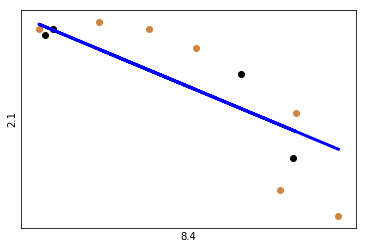

8.4 2.1
MAE: 0.58667
RMSE: 0.67395
R2: 0.670
Coefficient -0.9221183800623053
--------------------------


7.2 9.5
MAE: 5.61988
RMSE: 7.55828
R2: 0.367
Coefficient 15.080460502366218
--------------------------




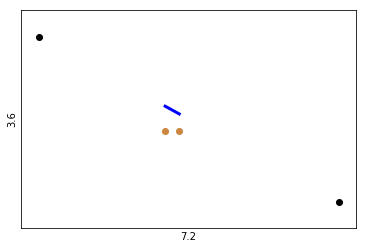

7.2 3.6
MAE: 0.01766
RMSE: 0.01796
R2: nan
Coefficient -0.10937499999999997
--------------------------


7.2 15.1
MAE: 2.65733
RMSE: 3.65656
R2: 0.103
Coefficient 3.8741354204586806
--------------------------


7.2 4.2
MAE: 1.42205
RMSE: 1.76248
R2: 0.695
Coefficient 5.952260042637788
--------------------------


7.2 8.1
MAE: 1.29869
RMSE: 1.71386
R2: 0.052
Coefficient -0.510921004732436
--------------------------




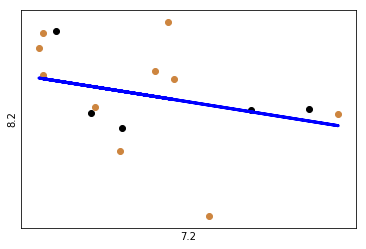

7.2 8.2
MAE: 0.99562
RMSE: 1.26410
R2: 0.143
Coefficient -0.812795777211503
--------------------------




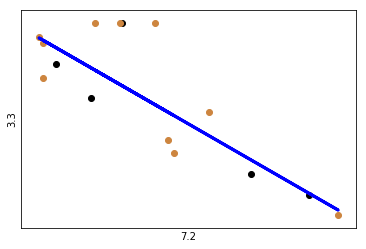

7.2 3.3
MAE: 0.47639
RMSE: 0.59943
R2: 0.587
Coefficient -1.7409901710957407
--------------------------




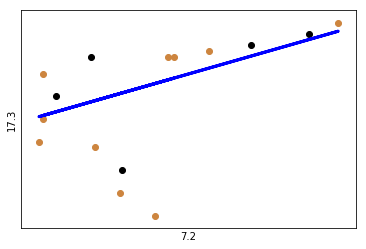

7.2 17.3
MAE: 0.07384
RMSE: 0.10162
R2: 0.138
Coefficient 0.10456862031306881
--------------------------


7.2 9.c
MAE: 8.90295
RMSE: 10.99382
R2: 0.417
Coefficient 17.902348016017477
--------------------------


7.2 17.8
MAE: 5.91454
RMSE: 7.77572
R2: 0.451
Coefficient 18.269475791772827
--------------------------


7.2 15.4
MAE: 2.04991
RMSE: 2.90648
R2: 0.231
Coefficient 4.592737531852925
--------------------------


7.2 7.1
MAE: 3.37817
RMSE: 4.03400
R2: nan
Coefficient 4.894366197183105
--------------------------


7.2 6.2
MAE: 1.58846
RMSE: 2.14916
R2: 0.413
Coefficient -4.585092828540222
--------------------------


7.2 6.1
MAE: 4.05293
RMSE: 5.01209
R2: 0.201
Coefficient 6.243993447397157
--------------------------


7.2 14.4
MAE: 4.23050
RMSE: 4.96439
R2: 0.117
Coefficient 5.27536453164363
--------------------------




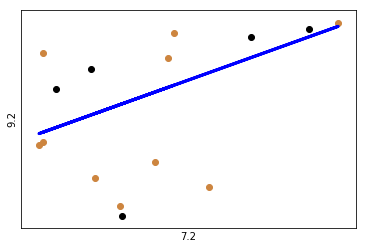

7.2 9.2
MAE: 0.33938
RMSE: 0.41384
R2: 0.019
Coefficient 0.4720604295595195
--------------------------




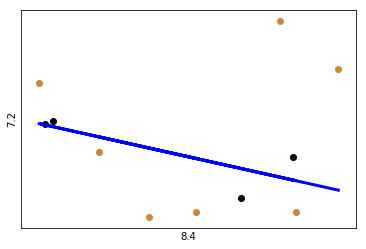

8.4 7.2
MAE: 0.29162
RMSE: 0.35259
R2: 0.000
Coefficient -0.13333333333333353
--------------------------




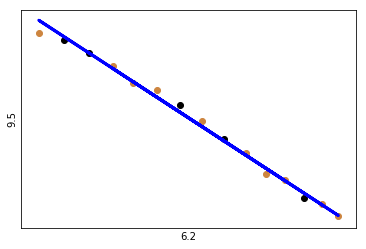

6.2 9.5
MAE: 0.64560
RMSE: 0.89635
R2: 0.991
Coefficient -3.4689276800355158
--------------------------




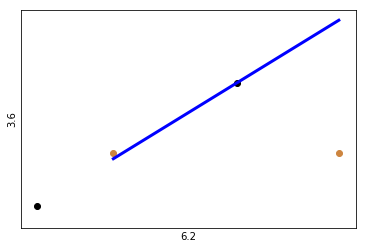

6.2 3.6
MAE: 0.07880
RMSE: 0.10697
R2: nan
Coefficient 0.02550091074681242
--------------------------


6.2 3.1
MAE: 1.57171
RMSE: 1.79093
R2: nan
Coefficient 1.0285714285714287
--------------------------




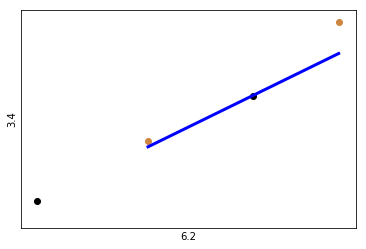

6.2 3.4
MAE: 0.01527
RMSE: 0.01862
R2: nan
Coefficient 0.012571428571428584
--------------------------


6.2 15.1
MAE: 1.35233
RMSE: 1.58624
R2: 0.831
Coefficient -0.9726985260553945
--------------------------




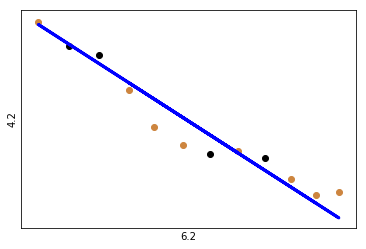

6.2 4.2
MAE: 0.80352
RMSE: 1.02382
R2: 0.897
Coefficient -1.5200732298637945
--------------------------


6.2 16.a
MAE: 4.99514
RMSE: 6.20180
R2: nan
Coefficient -1.085714285714286
--------------------------


6.2 8.1
MAE: 1.32755
RMSE: 1.77704
R2: 0.000
Coefficient 0.012834435233313207
--------------------------




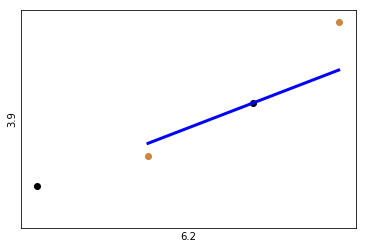

6.2 3.9
MAE: 0.01311
RMSE: 0.01512
R2: nan
Coefficient 0.0051428571428571435
--------------------------


6.2 8.2
MAE: 1.10410
RMSE: 1.37796
R2: 0.000
Coefficient 0.059712426192334356
--------------------------




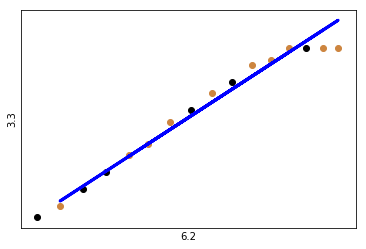

6.2 3.3
MAE: 0.15739
RMSE: 0.21455
R2: 0.947
Coefficient 0.3560437618718067
--------------------------




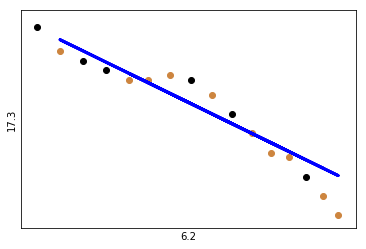

6.2 17.3
MAE: 0.02936
RMSE: 0.03804
R2: 0.879
Coefficient -0.031122539130946956
--------------------------


6.2 14.5
MAE: 1.30300
RMSE: 1.72218
R2: nan
Coefficient -1.29
--------------------------


6.2 9.c
MAE: 6.69343
RMSE: 8.13504
R2: 0.681
Coefficient -4.235361786403193
--------------------------




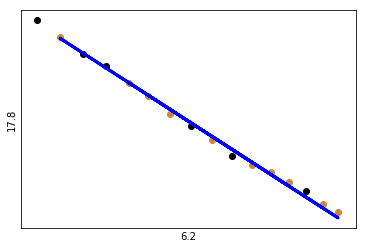

6.2 17.8
MAE: 0.54934
RMSE: 0.63737
R2: 0.996
Coefficient -3.855544961936596
--------------------------




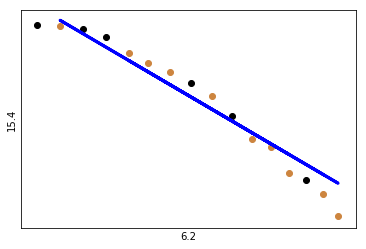

6.2 15.4
MAE: 0.69003
RMSE: 0.82222
R2: 0.938
Coefficient -0.9721132183823421
--------------------------




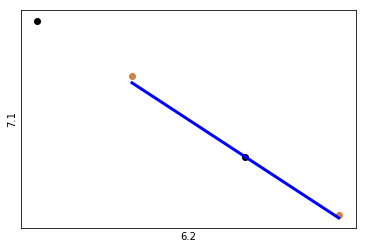

6.2 7.1
MAE: 0.25087
RMSE: 0.26437
R2: nan
Coefficient -1.1137820512820524
--------------------------


6.2 6.1
MAE: 2.06647
RMSE: 2.27683
R2: 0.835
Coefficient -1.3773117812495397
--------------------------


6.2 14.4
MAE: 3.14004
RMSE: 3.54782
R2: 0.549
Coefficient -1.3928777300967148
--------------------------




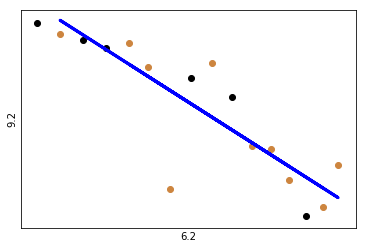

6.2 9.2
MAE: 0.18285
RMSE: 0.26142
R2: 0.608
Coefficient -0.13212308394563627
--------------------------




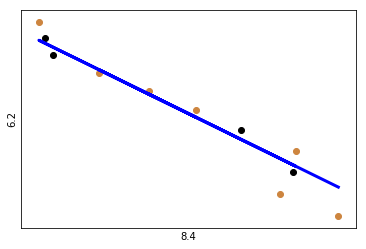

8.4 6.2
MAE: 0.50819
RMSE: 0.62736
R2: 0.904
Coefficient -2.232834890965733
--------------------------


6.1 9.5
MAE: 2.44096
RMSE: 2.75772
R2: 0.916
Coefficient 1.9132389963815524
--------------------------




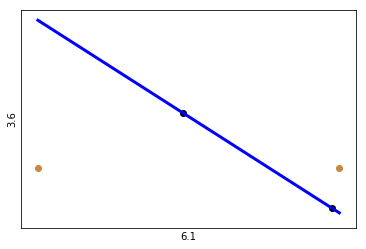

6.1 3.6
MAE: 0.14097
RMSE: 0.15948
R2: nan
Coefficient -0.019310344827586225
--------------------------


6.1 3.1
MAE: 2.93421
RMSE: 3.05339
R2: nan
Coefficient -1.052631578947368
--------------------------




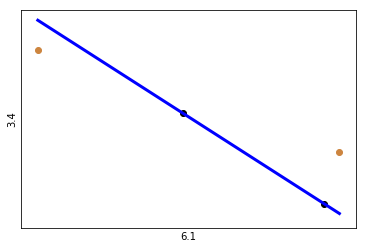

6.1 3.4
MAE: 0.04442
RMSE: 0.04692
R2: nan
Coefficient -0.012865497076023398
--------------------------




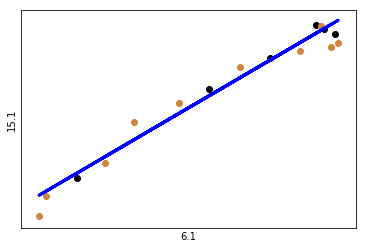

6.1 15.1
MAE: 0.76300
RMSE: 0.86365
R2: 0.950
Coefficient 0.6960482991542924
--------------------------


6.1 4.2
MAE: 2.72579
RMSE: 3.04096
R2: 0.091
Coefficient 1.1111448786553375
--------------------------


6.1 16.a
MAE: 3.66111
RMSE: 3.66890
R2: nan
Coefficient 1.1111111111111107
--------------------------


6.1 8.1
MAE: 1.32450
RMSE: 1.76543
R2: 0.000
Coefficient -0.01404271595976484
--------------------------




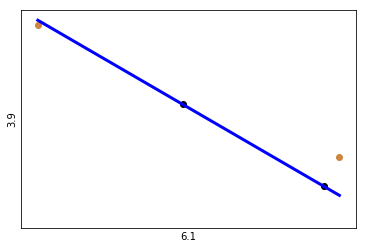

6.1 3.9
MAE: 0.00942
RMSE: 0.01203
R2: nan
Coefficient -0.005263157894736839
--------------------------


6.1 8.2
MAE: 1.14002
RMSE: 1.38645
R2: 0.000
Coefficient -0.009173205717458449
--------------------------




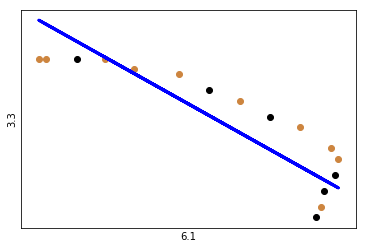

6.1 3.3
MAE: 0.50434
RMSE: 0.55827
R2: 0.642
Coefficient -0.21180780873261157
--------------------------




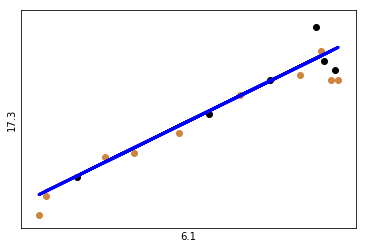

6.1 17.3
MAE: 0.02495
RMSE: 0.03337
R2: 0.907
Coefficient 0.020364443369029768
--------------------------


6.1 14.5
MAE: 6.77728
RMSE: 6.90470
R2: nan
Coefficient 1.3201754385964903
--------------------------


6.1 9.c
MAE: 6.53725
RMSE: 9.63175
R2: 0.553
Coefficient 2.965066946600366
--------------------------


6.1 17.8
MAE: 4.45391
RMSE: 4.94311
R2: 0.778
Coefficient 2.297665005884229
--------------------------




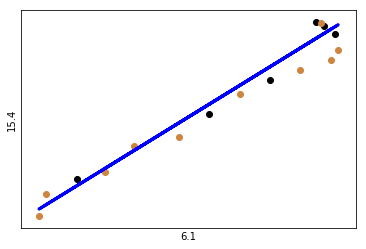

6.1 15.4
MAE: 0.73722
RMSE: 0.87295
R2: 0.931
Coefficient 0.6517383630151858
--------------------------


6.1 7.1
MAE: 3.66126
RMSE: 3.67431
R2: nan
Coefficient 0.9844192634560905
--------------------------


6.1 14.4
MAE: 4.18651
RMSE: 4.62687
R2: 0.233
Coefficient 1.1328731977017308
--------------------------




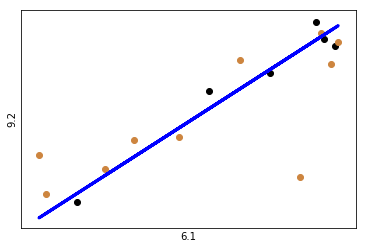

6.1 9.2
MAE: 0.23499
RMSE: 0.34790
R2: 0.306
Coefficient 0.09280584243464102
--------------------------




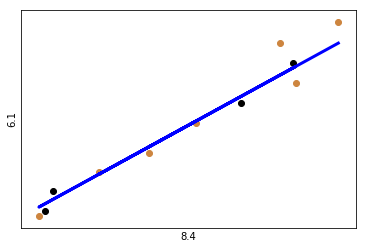

8.4 6.1
MAE: 0.94574
RMSE: 1.23218
R2: 0.937
Coefficient 5.901682242990654
--------------------------


14.4 9.5
MAE: 7.82801
RMSE: 8.38721
R2: 0.261
Coefficient 2.2745670995670997
--------------------------


14.4 15.1
MAE: 3.17385
RMSE: 3.63093
R2: 0.228
Coefficient 0.4821428571428563
--------------------------


14.4 4.2
MAE: 2.57881
RMSE: 3.15786
R2: 0.072
Coefficient 0.17424242424242725
--------------------------


14.4 8.1
MAE: 1.83909
RMSE: 2.27947
R2: 0.190
Coefficient -0.13528138528138522
--------------------------


14.4 8.2
MAE: 1.45557
RMSE: 1.62939
R2: 0.000
Coefficient -0.20238095238095233
--------------------------




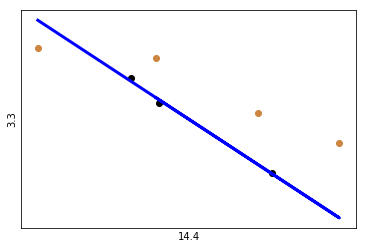

14.4 3.3
MAE: 0.97484
RMSE: 1.03541
R2: 0.000
Coefficient -0.28138528138528157
--------------------------




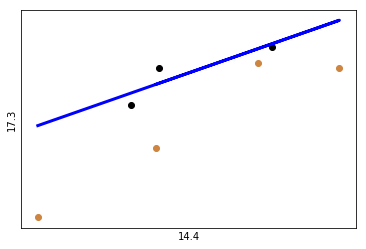

14.4 17.3
MAE: 0.10214
RMSE: 0.11481
R2: 0.073
Coefficient 0.01406926406926406
--------------------------


14.4 9.c
MAE: 12.10073
RMSE: 13.52010
R2: 0.000
Coefficient 2.3495670995671003
--------------------------


14.4 17.8
MAE: 8.26737
RMSE: 9.69319
R2: 0.015
Coefficient 2.89177489177489
--------------------------


14.4 15.4
MAE: 2.81170
RMSE: 2.86120
R2: 0.322
Coefficient 0.6617965367965364
--------------------------




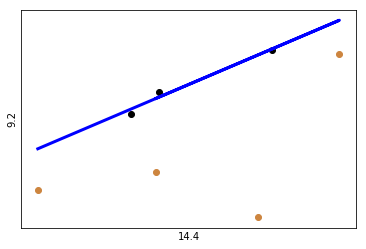

14.4 9.2
MAE: 0.46524
RMSE: 0.55680
R2: 0.000
Coefficient 0.05465367965367972
--------------------------


8.4 14.4
MAE: 3.14000
RMSE: 3.57269
R2: 0.279
Coefficient 3.666666666666673
--------------------------


9.2 9.5
MAE: 3.82273
RMSE: 6.10167
R2: 0.587
Coefficient 20.459194619070672
--------------------------




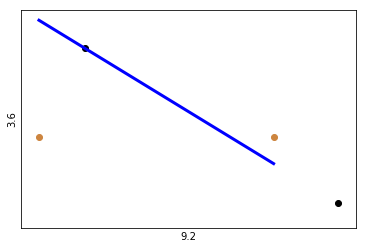

9.2 3.6
MAE: 0.06507
RMSE: 0.07668
R2: nan
Coefficient -0.19718309859154923
--------------------------


9.2 3.1
MAE: 2.28494
RMSE: 2.96362
R2: nan
Coefficient -8.674698795180719
--------------------------




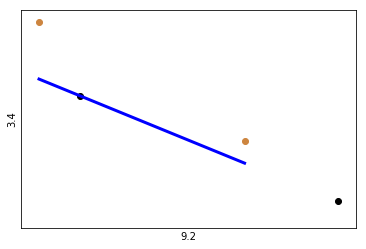

9.2 3.4
MAE: 0.03270
RMSE: 0.03578
R2: nan
Coefficient -0.10602409638554224
--------------------------


9.2 15.1
MAE: 1.55047
RMSE: 2.46216
R2: 0.600
Coefficient 7.004226474202307
--------------------------


9.2 4.2
MAE: 5.24233
RMSE: 6.71947
R2: 0.000
Coefficient 19.30703624733474
--------------------------


9.2 16.a
MAE: 4.16667
RMSE: 5.55488
R2: 0.370
Coefficient 19.99999999999972
--------------------------


9.2 8.1
MAE: 1.33374
RMSE: 1.77658
R2: 0.000
Coefficient 0.129003238575026
--------------------------




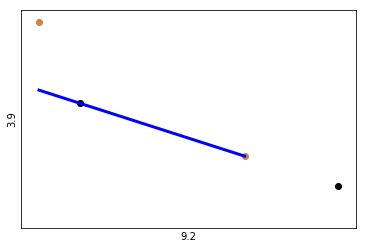

9.2 3.9
MAE: 0.01469
RMSE: 0.02076
R2: nan
Coefficient -0.04337349397590361
--------------------------


9.2 8.2
MAE: 1.05272
RMSE: 1.32202
R2: 0.000
Coefficient 0.04110347435083692
--------------------------




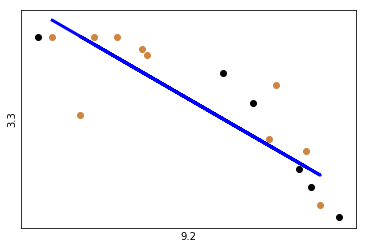

9.2 3.3
MAE: 0.47325
RMSE: 0.60749
R2: 0.576
Coefficient -2.2247211227060113
--------------------------




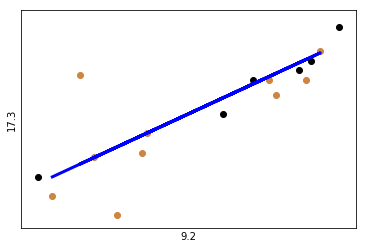

9.2 17.3
MAE: 0.05008
RMSE: 0.07784
R2: 0.494
Coefficient 0.22112270600935605
--------------------------


9.2 14.5
MAE: 3.52200
RMSE: 4.16030
R2: 0.000
Coefficient 16.39999999999978
--------------------------


9.2 9.c
MAE: 6.89545
RMSE: 9.99432
R2: 0.518
Coefficient 31.326286433969074
--------------------------


9.2 17.8
MAE: 4.78629
RMSE: 6.67991
R2: 0.595
Coefficient 24.1953940266283
--------------------------


9.2 15.4
MAE: 1.37305
RMSE: 2.03431
R2: 0.651
Coefficient 6.526688901791868
--------------------------


9.2 7.1
MAE: 1.26833
RMSE: 1.35158
R2: nan
Coefficient 9.26666666666665
--------------------------




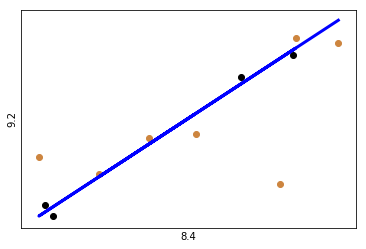

8.4 9.2
MAE: 0.20548
RMSE: 0.31303
R2: 0.052
Coefficient 0.5396261682242991
--------------------------


8.4 9.5
MAE: 1.72828
RMSE: 2.04544
R2: 0.922
Coefficient 8.490554517133955
--------------------------




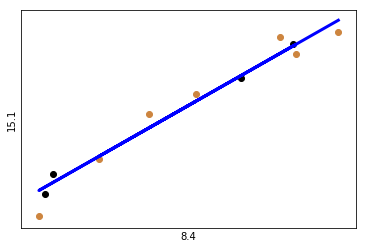

8.4 15.1
MAE: 0.68818
RMSE: 0.77889
R2: 0.949
Coefficient 4.436137071651092
--------------------------




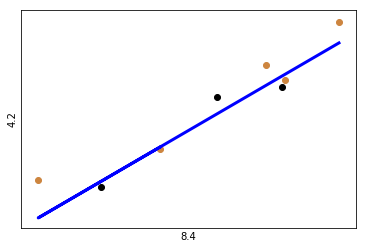

8.4 4.2
MAE: 0.41259
RMSE: 0.51328
R2: 0.858
Coefficient 2.470487215367005
--------------------------


8.4 8.1
MAE: 1.82093
RMSE: 2.19188
R2: 0.000
Coefficient 0.2876012461059194
--------------------------


8.4 8.2
MAE: 1.32384
RMSE: 1.65040
R2: 0.000
Coefficient 0.9172585669781937
--------------------------




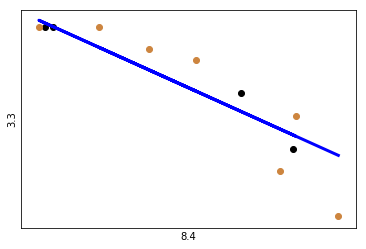

8.4 3.3
MAE: 0.25943
RMSE: 0.29880
R2: 0.769
Coefficient -0.5775700934579425
--------------------------




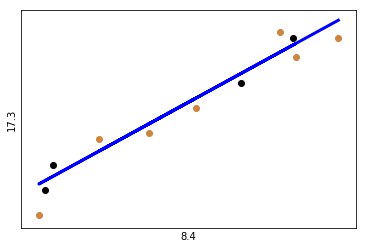

8.4 17.3
MAE: 0.02570
RMSE: 0.02814
R2: 0.915
Coefficient 0.1233021806853583
--------------------------


8.4 9.c
MAE: 7.58750
RMSE: 10.21922
R2: 0.264
Coefficient 16.44735202492212
--------------------------


8.4 17.8
MAE: 2.10170
RMSE: 2.72705
R2: 0.859
Coefficient 7.3968224299065435
--------------------------




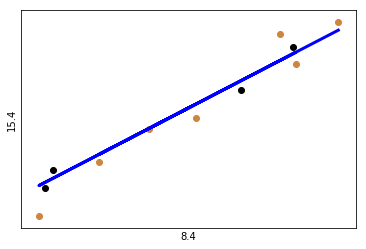

8.4 15.4
MAE: 0.59433
RMSE: 0.72947
R2: 0.931
Coefficient 3.138193146417447
--------------------------


10.c 9.5
MAE: 1.76575
RMSE: 1.91137
R2: nan
Coefficient -5.294999999999985
--------------------------




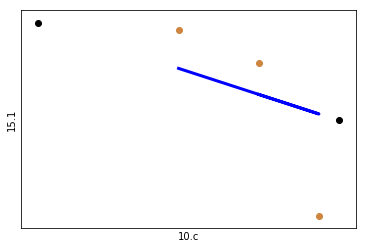

10.c 15.1
MAE: 0.31044
RMSE: 0.35582
R2: 0.346
Coefficient -0.3533333333333293
--------------------------


10.c 4.2
MAE: 1.48500
RMSE: 1.62304
R2: nan
Coefficient -1.4000000000000052
--------------------------




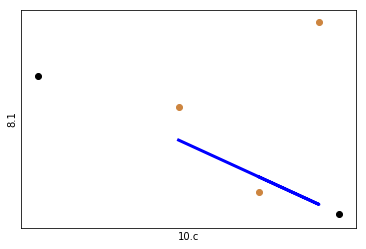

10.c 8.1
MAE: 0.24444
RMSE: 0.34181
R2: 0.000
Coefficient -0.2933333333333332
--------------------------




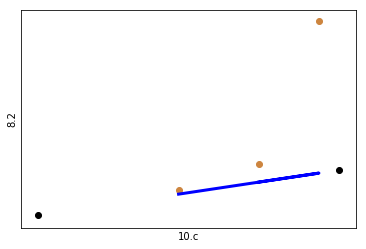

10.c 8.2
MAE: 0.29644
RMSE: 0.45092
R2: 0.000
Coefficient 0.15333333333333327
--------------------------




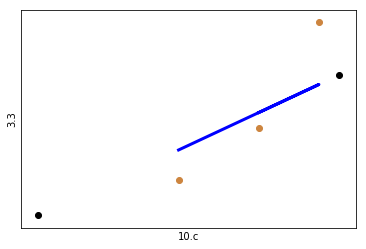

10.c 3.3
MAE: 0.20444
RMSE: 0.23267
R2: 0.613
Coefficient 0.5333333333333335
--------------------------




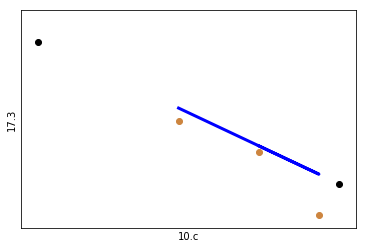

10.c 17.3
MAE: 0.01267
RMSE: 0.01587
R2: 0.595
Coefficient -0.05999999999999996
--------------------------


10.c 9.c
MAE: 1.28444
RMSE: 1.36841
R2: 0.142
Coefficient -1.7333333333333292
--------------------------


10.c 17.8
MAE: 1.54333
RMSE: 2.20452
R2: 0.631
Coefficient -5.966666666666667
--------------------------




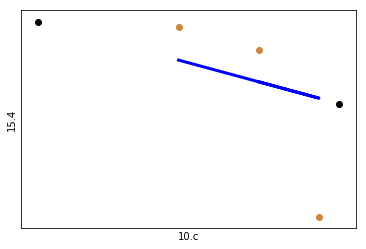

10.c 15.4
MAE: 0.46511
RMSE: 0.55810
R2: 0.245
Coefficient -0.41333333333333633
--------------------------




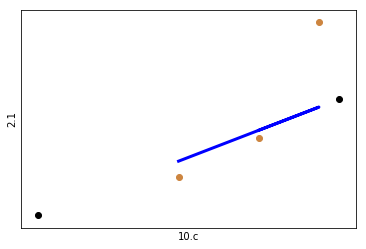

10.c 2.1
MAE: 0.18667
RMSE: 0.25923
R2: 0.418
Coefficient 0.3999999999999997
--------------------------




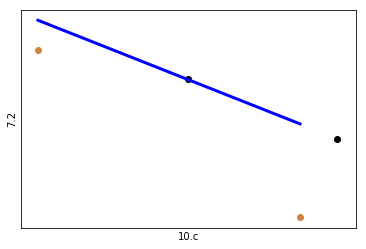

10.c 7.2
MAE: 0.29000
RMSE: 0.32650
R2: nan
Coefficient -0.7000000000000026
--------------------------




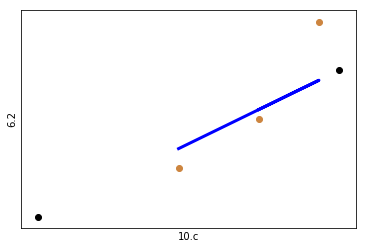

10.c 6.2
MAE: 0.44422
RMSE: 0.54828
R2: 0.653
Coefficient 1.506666666666667
--------------------------




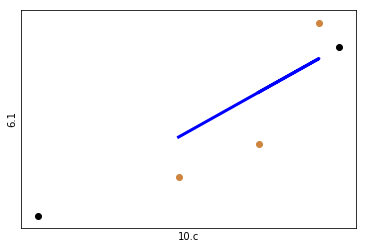

10.c 6.1
MAE: 0.24200
RMSE: 0.24497
R2: 0.580
Coefficient 0.6400000000000005
--------------------------




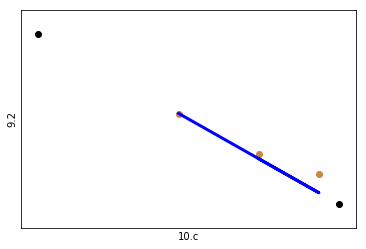

10.c 9.2
MAE: 0.00800
RMSE: 0.01112
R2: 0.801
Coefficient -0.11333333333333326
--------------------------




In [27]:
keptPairs = list()
processedPairs = list()
notPercentTargets = ['12.2', '9.4', '8.4', '17.2', '17.19']   # work on this
highValueTargets = ['9.4', '17.19']
discardedPairs = list()
edgecolor = list()
pairsAndRel = {}

n_connections = 0

for targetx in targets:     #loop over all rows
        
        for targety in targets:    #loop over all rows except the one we're in now
            # avoid double processing of reverse pairs
            if not set([targetx, targety]) in processedPairs:
                processedPairs.extend([set([targetx, targety])])
                
                if not targety==targetx:
                    
                    if ((targety in notPercentTargets and not targetx in notPercentTargets) or targety in highValueTargets):
                        y = targetx
                        x = targety
                        targetx = x
                        targety = y


                    X = final_t_shuffled[targetx].reshape(-1,1)
                    Y = final_t_shuffled[targety].reshape(-1,1)

                    # apply mask to lists to filter out pairs containing any NaNs
                    mask = ~pd.isnull(X) & ~pd.isnull(Y)

                    X = X[mask]
                    Y = Y[mask]


                    # Split the data into training/testing sets
                    split = math.floor(2/3 * len(X))
                    X_train = X[:-split]
                    Y_train = Y[:-split]

                    X_valid = X[-split:]
                    Y_valid = Y[-split:]


                    if (len(X_train) > 1):

                        X_train = X_train.reshape(-1, 1)
                        Y_train = Y_train.reshape(-1, 1)
                        
                        X_valid = X_valid.reshape(-1, 1)
                        Y_valid = Y_valid.reshape(-1, 1)

                        linreg = linear_model.LinearRegression()
                        linreg.fit(X_train, Y_train)
                        
                        # Make predictions using the validation values
                        y_pred = linreg.predict(X_valid)
                        mae, rae, rmse, r2 = compute_error(Y_valid, y_pred)
                        
                        
                        coef = linreg.coef_[0][0]
                        
                        # filter out independant variables (coefficient close to 0, coefficient > 100)
                        if (0.001 < np.abs(coef) < 100):
                        
                            if targety in notPercentTargets:

                                if 0<=mae<0.1: # 1 percent tolerance (converted to tonnes)
                                    #print('MAE', targetx, targety, mae)
                                    keptPairs.extend([tuple((targetx, targety))])

                                    if coef > 0: edge_color = 'g'#edgecolor.append('g')
                                    else: edge_color = 'r'
                                    
                                    edgecolor.append(edge_color)
                                    pairsAndRel[targetx, targety] = edge_color

                                    plt.scatter(X_train, Y_train,  color='black')
                                    plt.scatter(X_valid, Y_valid, color='peru')
                                    plt.plot(X_valid, y_pred, color='blue', linewidth=3)

                                    plt.xticks(())
                                    plt.yticks(())
                                    plt.xlabel(targetx)
                                    plt.ylabel(targety)
                                    plt.show()

                                    n_connections = n_connections + 1

                                else: discardedPairs.extend([[targetx, targety]])


                            else:
                                if 1 > mae > 0: # tolerate 1 percent error
                                    keptPairs.extend([tuple((targetx, targety))])
                                    
                                    if coef > 0: edge_color = 'g'#edgecolor.append('g')
                                    else: edge_color = 'r'
                                    
                                    edgecolor.append(edge_color)
                                    pairsAndRel[targetx, targety] = edge_color

                                    plt.scatter(X_train, Y_train,  color='black')
                                    plt.scatter(X_valid, Y_valid, color='peru')
                                    plt.plot(X_valid, y_pred, color='blue', linewidth=3)

                                    plt.xticks(())
                                    plt.yticks(())
                                    plt.xlabel(targetx)
                                    plt.ylabel(targety)
                                    plt.show()

                                    n_connections = n_connections + 1

                                else: discardedPairs.extend([[targetx, targety]])
                        
                        else: discardedPairs.extend([[targetx, targety]])

                        print(targetx, targety)
                        
                        print("MAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (mae, rmse, r2))
                        print('Coefficient', coef)
                        print('--------------------------')
                        print('\n')

#print(keptPairs)

In [28]:
print("Total number of connections found: ", n_connections)

Total number of connections found:  119


In [29]:
print(keptPairs)

[('3.1', '3.4'), ('3.1', '8.1'), ('3.1', '3.9'), ('3.4', '8.1'), ('3.4', '3.9'), ('15.1', '3.9'), ('16.a', '8.1'), ('16.a', '3.9'), ('8.1', '3.9'), ('8.1', '8.2'), ('3.3', '3.6'), ('3.3', '3.4'), ('3.3', '4.2'), ('3.3', '3.9'), ('3.3', '17.3'), ('3.3', '14.5'), ('17.3', '3.6'), ('17.3', '3.1'), ('17.3', '3.4'), ('17.3', '15.1'), ('17.3', '3.9'), ('14.5', '3.4'), ('14.5', '8.1'), ('14.5', '3.9'), ('9.c', '3.6'), ('9.c', '3.4'), ('9.c', '3.9'), ('17.8', '3.6'), ('17.8', '3.4'), ('17.8', '4.2'), ('17.8', '3.9'), ('17.8', '3.3'), ('17.8', '17.3'), ('17.8', '15.4'), ('17.8', '7.1'), ('12.2', '2.1'), ('12.2', '7.2'), ('12.2', '6.2'), ('12.2', '6.1'), ('12.2', '9.2'), ('12.2', '8.4'), ('15.4', '3.6'), ('15.4', '3.1'), ('15.4', '3.4'), ('15.4', '15.1'), ('15.4', '3.9'), ('15.4', '3.3'), ('15.4', '17.3'), ('12.2', '15.4'), ('7.1', '8.1'), ('7.1', '3.3'), ('7.1', '17.3'), ('12.2', '15.1'), ('12.2', '4.2'), ('12.2', '3.3'), ('12.2', '17.3'), ('2.1', '3.6'), ('2.1', '3.4'), ('2.1', '3.9'), ('2.1',

In [30]:
# seems like the high value targets are discarded more than the others, else, evenly distributed
print(discardedPairs)

[['9.4', '9.5'], ['9.4', '3.6'], ['9.4', '15.1'], ['9.4', '4.2'], ['9.4', '8.1'], ['9.4', '8.2'], ['9.4', '17.2'], ['9.4', '3.3'], ['9.4', '17.3'], ['9.4', '9.c'], ['17.19', '9.4'], ['17.19', '17.8'], ['17.19', '15.4'], ['17.19', '12.2'], ['17.19', '2.1'], ['17.19', '7.2'], ['17.19', '6.2'], ['17.19', '6.1'], ['17.19', '14.4'], ['17.19', '9.2'], ['17.19', '8.4'], ['17.19', '10.c'], ['9.4', '17.8'], ['9.4', '15.4'], ['9.4', '7.1'], ['9.4', '12.2'], ['9.4', '2.1'], ['9.4', '7.2'], ['9.4', '6.2'], ['9.4', '6.1'], ['9.4', '14.4'], ['9.4', '9.2'], ['9.4', '8.4'], ['9.4', '10.c'], ['3.6', '9.5'], ['3.6', '15.1'], ['3.6', '8.1'], ['3.6', '8.2'], ['17.2', '3.6'], ['17.2', '3.3'], ['17.2', '17.3'], ['17.2', '14.5'], ['17.2', '9.c'], ['17.19', '17.2'], ['3.1', '15.1'], ['3.1', '16.a'], ['3.1', '8.2'], ['17.2', '3.1'], ['17.2', '17.8'], ['17.2', '15.4'], ['17.2', '7.1'], ['17.2', '12.2'], ['17.2', '2.1'], ['17.2', '7.2'], ['17.2', '6.2'], ['17.2', '6.1'], ['17.2', '14.4'], ['17.2', '9.2'], ['17.2

## 2. Graphical Models

In [31]:
import networkx as nx

In [32]:
G1 = nx.Graph()
G1.add_edges_from(keptPairs)

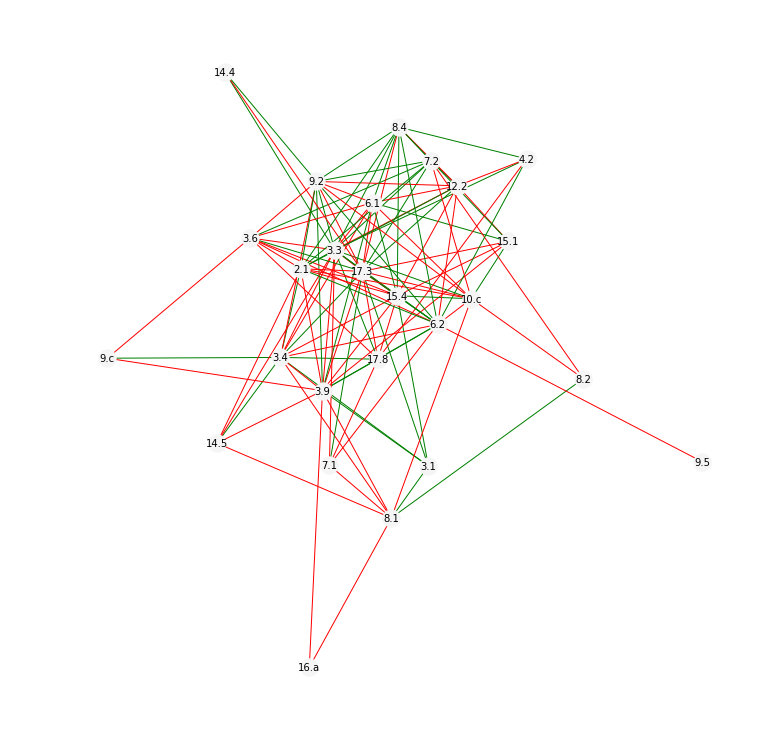

In [33]:
pos2 = nx.spring_layout(G1) # choose layout

plt.figure(1,figsize=(10,10)) 
nx.draw(G1,pos2, with_labels=True, edge_color=edgecolor, node_color='whitesmoke', font_size=10)
plt.savefig("structure.png")
plt.show()

In this plot, the most connected and therefore most influential nodes are located in the middle of the graph.

In [34]:
from matplotlib.pyplot import imshow
%matplotlib inline
from PIL import Image

size = 1024,1024
circles = Image.open("Circle-Designs-01.png")
circles = circles.resize(size, Image.ANTIALIAS)
plot = Image.open("structure.png")
plot = plot.resize(size, Image.ANTIALIAS)
overlay = Image.blend(circles, plot,alpha=0.7)
overlay.show()
overlay.save("final.png")
#imshow(np.asarray(overlay), aspect='equal')

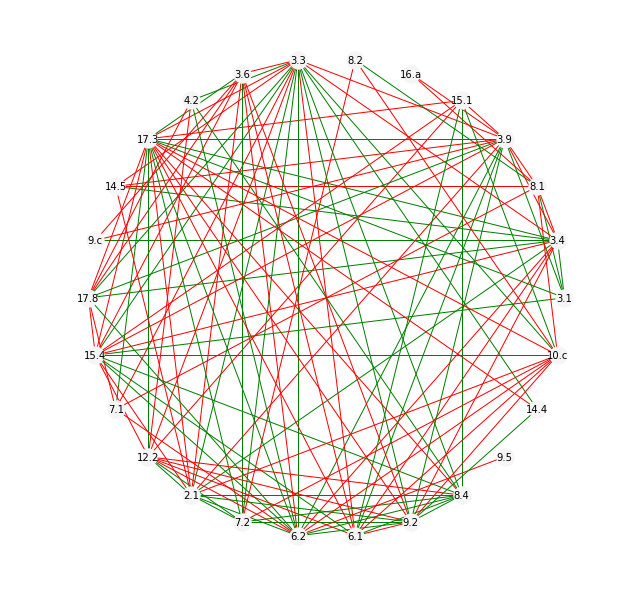

In [35]:
pos = nx.circular_layout(G1) # choose layout
# default

plt.figure(1,figsize=(8,8)) 
nx.draw(G1,pos, with_labels=True, edge_color=edgecolor, node_color='whitesmoke', font_size=10)
plt.show()

In [36]:
clique_list = list(nx.find_cliques(G1))
clique_list

[['3.3', '4.2', '6.2', '12.2', '8.4'],
 ['3.3', '4.2', '6.2', '17.8'],
 ['3.3', '14.5', '3.9', '2.1', '3.4'],
 ['3.3', '17.3', '7.2', '9.2', '2.1', '12.2', '8.4'],
 ['3.3', '17.3', '7.2', '9.2', '2.1', '3.6'],
 ['3.3', '17.3', '7.2', '9.2', '2.1', '10.c'],
 ['3.3', '17.3', '14.4', '9.2'],
 ['3.3', '17.3', '6.2', '9.2', '2.1', '3.6'],
 ['3.3', '17.3', '6.2', '9.2', '2.1', '3.4', '3.9'],
 ['3.3', '17.3', '6.2', '9.2', '2.1', '12.2', '8.4'],
 ['3.3', '17.3', '6.2', '9.2', '2.1', '10.c'],
 ['3.3', '17.3', '6.2', '7.1', '17.8'],
 ['3.3', '17.3', '6.2', '15.4', '2.1', '3.6'],
 ['3.3', '17.3', '6.2', '15.4', '2.1', '3.4', '3.9'],
 ['3.3', '17.3', '6.2', '15.4', '2.1', '12.2', '8.4'],
 ['3.3', '17.3', '6.2', '15.4', '2.1', '10.c'],
 ['3.3', '17.3', '6.2', '15.4', '17.8', '3.9', '3.4'],
 ['3.3', '17.3', '6.2', '15.4', '17.8', '3.6'],
 ['3.3', '17.3', '6.1', '9.2', '3.6'],
 ['3.3', '17.3', '6.1', '9.2', '3.4', '3.9'],
 ['3.3', '17.3', '6.1', '9.2', '12.2', '8.4'],
 ['3.3', '17.3', '6.1', '9.2', 

In [37]:
# finding clique containing most nodes
length = 0
for c in clique_list:
    if len(c) > length:
        length = len(c)
        max_clique = c

In [38]:
import itertools

def complete_graph_from_list(L, create_using=None):
    G = nx.empty_graph()
    if len(L)>1:
        if G.is_directed():
            edges = itertools.permutations(L,2)
        else:
            edges = itertools.combinations(L,2)
        G.add_edges_from(edges)
    return G


In [39]:
cliqueGraph = complete_graph_from_list(max_clique)

In [40]:
cliqueGraph_edges = list(cliqueGraph.edges)
pairsDictListKeys = list(pairsAndRel.keys())

In [41]:
clique_e_color = []
for edge in cliqueGraph_edges:
    if edge in pairsDictListKeys:
        clique_e_color.append(pairsAndRel[edge])
    elif edge[::-1] in pairsDictListKeys:
        clique_e_color.append(pairsAndRel[edge[::-1]])

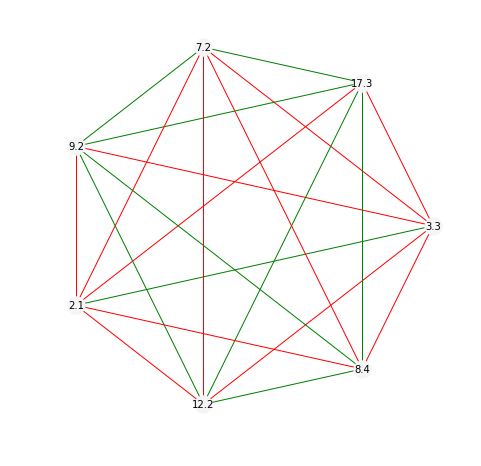

In [42]:
#cliqueGraph.add_nodes_from(max_clique)
pos9 = nx.shell_layout(cliqueGraph)
plt.figure(1,figsize=(6,6)) 
nx.draw(cliqueGraph,pos9, with_labels=True, font_size=10, edge_color=clique_e_color, node_color='whitesmoke')
plt.show()

## 2. Build temporal model to infer missing observations

We have a temporal model with missing observations as NaNs, and want to infer them

In [43]:
# convert data to a matrix
y = df.as_matrix()
y = y[:(6*24*1)]
N, D = y.shape
print("N=%d, D=%d" % (N,D))

N=144, D=43


# What is observed and what is missing?

#perm1 = np.random.permutation(N)
ix_mis1 = perm1[:int(missing_perc * N)] # missing indexes
ix_obs1 = perm1[int(missing_perc * N):] # observed indexes
y_mis1 = y[ix_mis1,7]
y_obs1 = y[ix_obs1,7]

#perm2 = np.random.permutation(N)
ix_mis2 = perm2[:int(missing_perc * N)] # missing indexes
ix_obs2 = perm2[int(missing_perc * N):] # observed indexes
y_mis2 = y[ix_mis2,8]
y_obs2 = y[ix_obs2,8]

N_obs = len(ix_obs1)
N_mis = len(ix_mis1)
print("N_obs:", N_obs)
print("N_mis:", N_mis)

## Define STAN model

From now on, we can actually forget all information we've gotten so far. With the implementation in STAN, we will gain insights for the following two questions in one single model (wow - so amazing :-) ):

**1. How are Targets correlated?**

**2. What are expectable values for missing observations (imputing)?**

Note that we observe two time-series simultaneously. We will model the correlations between the two time-series in the latent state $\textbf{z}_t$. We will assume that our latent state is 2-dimensional $\textbf{z}_t = \{z_{t,1},z_{t,2}\}$ with latent dynamics:
\begin{align}
\textbf{z}_t &\sim \mathcal{N}(\boldsymbol\beta \textbf{z}_{t-1}, \boldsymbol\Sigma)
\end{align}
And likelihoods:
\begin{align}
y_{t,1} &\sim \mathcal{N}(z_{t,1}, \sigma^2)\\
y_{t,2} &\sim \mathcal{N}(z_{t,2}, \sigma^2)
\end{align}
Or (equivalent):
\begin{align}
\textbf{y}_t &\sim \mathcal{N}(\textbf{z}_t, \sigma^2 \textbf{I})
\end{align}

The key element in the model described above is the **covariance matrix $\boldsymbol\Sigma$** which embodies the object that will allow us to capture the correlations between the two time-series.

In STAN, the recommended approach is to decompose the covariance matrix $\boldsymbol\Sigma$ into a *scale* and a *matrix*, but we are able to do so in a more natural way based on the actual variable scales and a correlation matrix. Specifically, we define:

\begin{align}
\boldsymbol\Sigma = \mbox{diag_matrix}(\boldsymbol\tau) \, \boldsymbol\Omega \, \mbox{diag_matrix}(\boldsymbol\tau)
\end{align}

where $\mbox{diag_matrix}(\boldsymbol\tau)$ denotes a diagonal matrix with diagonal elements given by the vector $\boldsymbol\tau$. In this parameterization, $\boldsymbol\Omega$ can be regarded as a correlation matrix and $\boldsymbol\tau$ is a vector of coefficient scales.

Similar to any other variable, we also must assign priors to $\boldsymbol\tau$ and $\boldsymbol\Omega$. The components of the scale vector $\boldsymbol\tau$ can be given any reasonable prior for scales, but something weakly informative like a half-Cauchy distribution with a small scale is recommended, such as:

\begin{align}
\boldsymbol\tau ∼ Cauchy(0, 1.0) , \, \mbox{with the constraint:} \, \boldsymbol\tau > 0
\end{align}

As for the correlation matrix $\boldsymbol\Omega$, the STAN manual recommends a LKJ prior like:

\begin{align}
\boldsymbol\Omega ∼ LKJCorr(10.0)
\end{align}

Finally, we can define a multivariate Gaussian with parameters $\boldsymbol\mu$, $\boldsymbol\tau$ and $\boldsymbol\Omega$ using:

multi_normal(mu, quad_form_diag(Omega, tau))


To impute missing observations, we do

\begin{align}
y_{t} &\sim \mathcal{N} \Big(\beta_{1} y_{t-1} + \beta_{2} y_{t-2} + ... + \beta_{T} y_{t-T} \Big)
\end{align}

Note that we want to make the missing observation dependent on one previous observation. This is equivalent to define an autoregressive model of order 1.

In [44]:
SDG_STAN="""
data {
    int<lower = 0> N_obs1;
    int<lower = 0> N_mis1;    // how many do we want to infer
    int<lower = 0> N_obs2;  
    int<lower = 0> N_mis2;
    int<lower = 1, upper = N_obs1 + N_mis1> ix_obs1[N_obs1];    // index for observed time steps of target 1
    int<lower = 1, upper = N_obs1 + N_mis1> ix_mis1[N_mis1];
    int<lower = 1, upper = N_obs2 + N_mis2> ix_obs2[N_obs2];    // index for observed time steps of target 2
    int<lower = 1, upper = N_obs2 + N_mis2> ix_mis2[N_mis2];
    real y_obs1[N_obs1];         // observed time-series data for target 1
    real y_obs2[N_obs2];         // observed time-series data for target 2
}
parameters {
    vector[1] beta[2];            // state transition coefficients. 
    corr_matrix[2] Omega;       // gives us the correlation with **Omega[1,2]=Omega[2,1]=Cov(1,2)**; Omega[1,1]=Var(1);Omega[2,2]=Var(2)    1 is target 1, 2 is target 2
    vector<lower=0>[2] tau;
    real<lower=0> sigma;       // observation noise
    matrix[T,2] z;             // vector of latent states
    real y_mis1[N_mis1];        // missing time-series data to infer for target 1
    real y_mis2[N_mis2];        // missing time-series data to infer for target 2
}
model {
    for(i in 1:2)                   
        beta[i] ~ normal(0,1);            // prior on the auto-regressive coefficients
    tau ~ cauchy(0,1);
    Omega ~ lkj_corr(10.0);         // STAN manual Section 63.1 (recommendation is lkj_corr)
    sigma ~ cauchy(0,1);            // prior on the variance
    
    z[1,:] ~ normal(0,1);           // prior on first state
    
    for(t in 2:T) {
        vector[2] mu;                          // mu is a vector of the means of our multivariate normal 
        mu[1] = beta[1]' * z[(t-1):(t-1),1];   // mu[1] is the mean of target 1 
        mu[2] = beta[2]' * z[(t-1):(t-1),2];   // mu[2] is the mean of target 2
        z[t,:] ~ multi_normal(mu, quad_form_diag(Omega, tau)); // latent dynamics
    }
    
    y1 ~ normal(z[:,1], sigma);    // likelihood for target 1
    y2 ~ normal(z[:,2], sigma);    // likelihood for target 2
}
"""

# what to do next: define huge for loop over all what follows from here?

In [45]:
clique_nodes = list(cliqueGraph.nodes)
clique_nodes

['3.3', '17.3', '7.2', '9.2', '2.1', '12.2', '8.4']

In [46]:
clique_df_t = final_t[clique_nodes]
clique_df_t

Target,3.3,17.3,7.2,9.2,2.1,12.2,8.4
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991,NaN,NaN,NaN,NaN,18.6,NaN,NaN
1992,NaN,NaN,NaN,NaN,18.5,NaN,NaN
1993,NaN,NaN,NaN,NaN,18.2,NaN,NaN


In [72]:
clique_df_t = clique_df_t[clique_df_t.index > '1990']
clique_df_t

Target,3.3,17.3,7.2,9.2,2.1,12.2,8.4
1991,NaN,NaN,NaN,NaN,18.6,NaN,NaN
1992,NaN,NaN,NaN,NaN,18.5,NaN,NaN
1993,NaN,NaN,NaN,NaN,18.2,NaN,NaN
1994,NaN,NaN,NaN,NaN,17.8,NaN,NaN
1995,NaN,NaN,NaN,NaN,17.2,NaN,NaN
1996,NaN,NaN,NaN,NaN,16.6,NaN,NaN
1997,NaN,NaN,NaN,NaN,16.1,NaN,NaN
1998,NaN,NaN,NaN,NaN,15.7,NaN,NaN
1999,NaN,NaN,NaN,NaN,15.3,NaN,NaN
2000,17.2,0.37,17.45,15.15,15,8,8


In [74]:
o_1 = clique_df_t['17.3'].tolist()
print(o_1)
nan_loc1 = np.where(np.isnan(o_1))[0]
print(nan_loc1)
y_loc1 = np.where(~np.isnan(o_1))[0]
print(y_loc1)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.37, 0.41, 0.45, 0.49, 0.5, 0.54, 0.58, 0.62, 0.65, 0.66, 0.65, 0.65, 0.67, 0.69, 0.71, 0.76, nan, nan]
[ 0  1  2  3  4  5  6  7  8 25 26]
[ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


In [75]:
y_o_1 =[o_1[index] for index in y_loc1]
print(y_o_1)

[0.37, 0.41, 0.45, 0.49, 0.5, 0.54, 0.58, 0.62, 0.65, 0.66, 0.65, 0.65, 0.67, 0.69, 0.71, 0.76]


- N_obs: Number of observed values (length of loc array)
- N_mis: Number of missing values (length of loc array)
- ix_obs: indices of observed values
- ix_mis: indices of missing values
- y_obs: observed values

In [53]:
# prepare data for STAN model
def prepareInputData(df, target1, target2):
    t1_list = df[target1].tolist()
    t2_list = df[target2].tolist()
    
    ix_obs1 = np.where(~np.isnan(t1_list))[0]
    ix_obs2 = np.where(~np.isnan(t2_list))[0]
    
    ix_mis1 = np.where(np.isnan(t1_list))[0]
    ix_mis2 = np.where(np.isnan(t2_list))[0]
    
    y_obs1 = [t1_list[index] for index in ix_obs1]
    y_obs2 = [t2_list[index] for index in ix_obs2]
    
    N_obs1 = len(ix_obs1)
    N_obs2 = len(ix_obs2)
    
    N_mis1 = len(ix_mis1)
    N_mis2 = len(ix_mis2)
    
    data = {'N_obs1': N_obs1, 'N_mis1': N_mis1, 'N_obs2': N_obs2, 'N_mis2': N_mis2,
            'ix_obs1': ix_obs1+1, 'ix_mis1': ix_mis1+1, 'y_obs1': y_obs1, 
            'ix_obs2': ix_obs2+1, 'ix_mis2': ix_mis2+1, 'y_obs2': y_obs2}
    
    return data

In [51]:
%%time
# create STAN model object (compile STAN model)
sm = pystan.StanModel(model_code=SDG_STAN)

ValueError: Failed to parse Stan model 'anon_model_28aeca907337f9ace1b447ecd0fae64e'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

variable "T" does not exist.
  error in 'unknown file name' at line 19, column 13
  -------------------------------------------------
    17:     vector<lower=0>[2] tau;
    18:     real<lower=0> sigma;       // observation noise
    19:     matrix[T,2] z;             // vector of latent states
                    ^
    20:     real y_mis1[N_mis1];        // missing time-series data to infer for target 1
  -------------------------------------------------



In [ ]:
# run inference using MCMC sampling
fit = sm.sampling(data=data, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit)

In [ ]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays

In [ ]:
# what do we actually want to show? sigma and tau are performance measurements. Interesting for us, but we want to see more
fit.plot(["tau","sigma","lp__"]) # take vars from temporal model
plt.show()

#### Compute mean and standard devitions for the imputed values of the time-series and visualize them (in comparison with the corresponding true values):

In [ ]:
# get mean and standard devitions for predictions
y_hat1 = samples["y_mis1"].mean(axis=0)
y_std1 = samples["y_mis1"].std(axis=0)

y_hat2 = samples["y_mis2"].mean(axis=0)
y_std2 = samples["y_mis2"].std(axis=0)

In [ ]:
plt.plot(ix_obs1, y_obs1, "bo")
plt.plot(ix_mis1, y_mis1, "bx")
plt.plot(ix_mis1, y_hat, "rx")
#plt.plot(ix_mis, y_hat + y_std, "r--")
#plt.plot(ix_mis, y_hat - y_std, "r--")
plt.legend(["true","forecast","forecast + stddev","forecast - stddev"])

Compute error statistics of the model's imputations:

In [ ]:
def compute_error2(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [ ]:
# insert def compute_error if deleted above
corr, mae, rae, rmse, r2 = compute_error2(y_mis1, y_hat) #for missing variables
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

### What our for-loop will look like (-ish)

#### Questions
- Which targets do we want to pair and use for pairwise inference?
    - first find out which is the one giving the least error and continue from there?
    - all possible pairs?
- How about the timesteps?
- Use all times or first from 1990  (no data before 1990 for any of the targets we want to analyze

In [62]:
from scipy.stats import pearsonr

In [81]:
t1_list = clique_df_t['3.3'].tolist()
t2_list = clique_df_t['17.3'].tolist()

mask = ~pd.isnull(t1_list) & ~pd.isnull(t2_list)
print(mask)
t1_list = list(itertools.compress(t1_list, mask))#t1_list[mask]
t2_list = list(itertools.compress(t2_list, mask))

print(t1_list)
print(t2_list)
#correlation between two targets
corrCoef = pearsonr(t1_list, t2_list)
print(corrCoef)

[False False False False False False False False False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False False]
[17.2, 17.2, 17.2, 17.2, 17.0, 16.9, 16.6, 16.4, 16.1, 15.9, 15.5, 15.3, 15.0, 14.7, 14.4, 14.2]
[0.37, 0.41, 0.45, 0.49, 0.5, 0.54, 0.58, 0.62, 0.65, 0.66, 0.65, 0.65, 0.67, 0.69, 0.71, 0.76]
(-0.9071673688690944, 1.2427636154452607e-06)


In [84]:
def calcCorr(target1, target2):
    # list of values
    t1_list = clique_df_t[target1].tolist()
    t2_list = clique_df_t[target2].tolist()
                    
    #correlation between two targets
    mask = ~pd.isnull(t1_list) & ~pd.isnull(t2_list)
    t1_list = list(itertools.compress(t1_list, mask))#t1_list[mask]
    t2_list = list(itertools.compress(t2_list, mask))

                    
    #correlation between two targets
    corrCoef = pearsonr(t1_list, t2_list)[0]
    
    return corrCoef

To find out which pairs would give the most cartain results after inference, we want to find the pairs that have the highest correlation between each other (lowest uncertainty in prediction). This is why we first calculate the correlation coefficient and choose the pairs that give the highest correlation coefficients.

In [95]:
# find pairs with best correlation coefficient
bestCorrPairs = []
processedPairs = []
corrCoefs = []

for targetx in clique_nodes:     #loop over all rows
    
    bestCorrCoef = 0
    
    for targety in clique_nodes:    #loop over all rows except the one we're in now
        # avoid double processing of reverse pairs
        if not set([targetx, targety]) in processedPairs:
            processedPairs.extend([set([targetx, targety])])
                
            if not targety==targetx:
                corr = calcCorr(targetx, targety)
                if (np.abs(corr) > np.abs(bestCorrCoef) and not (corr==0 or corr==1)):
                    bestCorrCoef = corr
                    bestPair = tuple([targetx, targety])
        
        else: continue           
    
    bestCorrPairs.append(bestPair)
    corrCoefs.append(bestCorrCoef)
    
for i in range(0,len(bestCorrPairs)):
    print(bestCorrPairs[i], ': ', corrCoefs[i])


('3.3', '2.1') :  0.9877502596564228
('17.3', '12.2') :  0.971777540102766
('7.2', '2.1') :  -0.803812470380246
('9.2', '2.1') :  -0.8210704971629079
('2.1', '12.2') :  -0.8650963199873208
('2.1', '12.2') :  0
('2.1', '12.2') :  0


In [ ]:
# prepare input data
inData = prepareInputData(clique_df_t, targetx, targety)
                    
# run inference using MCMC sampling
fit = sm.sampling(data=inData, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit)

samples = fit.extract(permuted=True)